## Lectures
 - [Value functions approximation - RL by David Silver](https://www.youtube.com/watch?v=UoPei5o4fps&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&index=6)
    - Differentiable function approximators
    - Incremental methods
    - Batch methods (DQN)

### Reading:
 - [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/pdf/1312.5602.pdf)
 - [Human-level control through deep reinforcement
learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)
  - Preprocessing.
  - Deep Q-learning.
  - Hyperparameters

### Coding
This week we will apply Deep Q-Networks (DQN) to Pong.

### Explore the environment:
- https://gym.openai.com/envs/Pong-v0/

### install env: 
 - pip install atari-py

In [1]:
import gym
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize
import random 
import torch
import os
import time
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
class Preprocessor():
    def __init__(self, game, h, w, device, n_frame=4):
        self.game = game
        self.h, self.w = h, w
        self.set_box(game)
        self.n_frame = n_frame
        self.history = []
        self.device = device
    def set_box(self, game):
        if self.game == 'pong':
            self.box = [35, 193, 0, self.w]
        
    def phi(self, rbg, to_tensor=True):
        stack = None
        frame = self.rgb2gray(rbg)
        self.history.append(frame)
        if len(self.history) == self.n_frame:
            stack = np.stack(self.history)
            if to_tensor:
                stack = self.to_tensor([stack])
        self.history = self.history[-(self.n_frame-1):]
        return stack
    
    def to_tensor(self, frames):
        frame = torch.from_numpy(np.stack(frames)).float().to(self.device)
        return frame
    
    def rgb2gray(self, rgb):
        rgb = rgb[self.box[0]:self.box[1], self.box[2]: self.box[3]]
        rgb = np.array(Image.fromarray(rgb).resize((84,84)))
        gray = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
        delta_value = gray.max() - gray.min()
        gray = gray / delta_value
        return gray

In [4]:
preprocessor = Preprocessor('pong', 210, 160, device)

In [5]:
env = gym.make("Pong-v0")
observation = env.reset()

In [6]:
observation.shape

(210, 160, 3)

In [7]:
for action_id, name in enumerate(env.unwrapped.get_action_meanings()):
    print(action_id, name)

0 NOOP
1 FIRE
2 RIGHT
3 LEFT
4 RIGHTFIRE
5 LEFTFIRE


In [8]:
NOOP, RIGHT, LEFT= 0, 2, 3

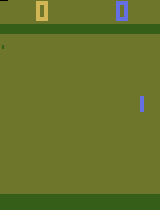

In [9]:
Image.fromarray(observation)

In [10]:
ob = env.reset()

(0.0, False, {'ale.lives': 0}, (84, 84))

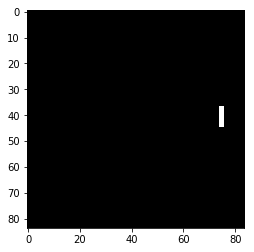

In [11]:
observation, reward, done, info = env.step(3)
frame = preprocessor.rgb2gray(observation)
plt.imshow(frame, cmap = "gray")
reward, done, info, frame.shape

In [12]:
ob = env.reset()

In [13]:
# i = 92
# t = D.D_win[i][0][0][0].cpu().numpy()
# plt.imshow(t, cmap = "gray")
# time.sleep(0.2)

In [14]:
# frame.shape

(0.0, False, {'ale.lives': 0}, (84, 84))

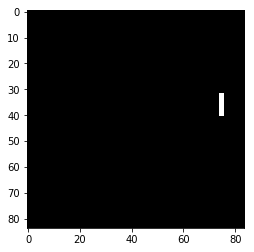

In [15]:
observation, reward, done, info = env.step(0)
frame = preprocessor.rgb2gray(observation)
frames = preprocessor.phi(observation)
plt.imshow(frame, cmap = "gray")
reward, done, info, frame.shape

### Build model:

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0],32,8,stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.fc = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(), 
            nn.Linear(512, n_actions))
    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [17]:
a = []
a.append(1)
a.append(2)
a

[1, 2]

In [18]:
a = [1,2,2,4]

In [19]:
a.pop()

4

In [20]:
a

[1, 2, 2]

In [21]:
40000//2

20000

### Data loader:

In [22]:
class DataLoader():
    def __init__(self, batch_size, win_buffer_start_size=1000, loss_buffer_start_size=3001, buffer_capacity=40000):
        self.batch_size = batch_size
        self.D_win = []
        self.D_lose = []
        self.buffer_capacity = buffer_capacity
        self.loss_buffer_start_size = loss_buffer_start_size
        self.win_buffer_start_size = win_buffer_start_size
        self.game = []
        
    def reset_game(self,):
        self.game = []
        
    def add_sample(self, sample):
        if sample:
            self.game.append(sample)
            reward = sample[2]
            
            if reward == -1:
                for step in self.game[30:]:
                    self.D_lose.append(step)
                self.reset_game()
                if len(self.D_lose) > self.buffer_capacity:
                    self.D_lose = self.D_lose[-(self.buffer_capacity // 2):]
            if reward == 1:
                for step in self.game[30:]:
                    self.D_win.append(step)
                self.reset_game()
                if len(self.D_win) > self.buffer_capacity:
                    self.D_win = self.D_win[-(self.buffer_capacity // 2):]
            
    def get_sample(self):
        batch = None
        is_mixed = True
        if len(self.D_win) > self.win_buffer_start_size:
            batch_win = random.sample(self.D_win, self.batch_size // 2)
            batch_lose = random.sample(self.D_lose, self.batch_size // 2)
            batch = batch_win + batch_lose
        elif len(self.D_lose) > self.loss_buffer_start_size:
            is_mixed = False
            batch = random.sample(self.D_lose, self.batch_size)
        return batch, is_mixed
    
    def __len__(self):
        return len(self.D_win), len(self.D_lose)
    
    def __getitem__(self, idx, is_win=False):
        if is_win:
            D = self.D_win
        else:
            D = self.D_lose
        if idx < 0 or idx > len(D) - 1:
            return None
        return D[idx]

In [23]:
0.992**200

0.20060161764521295

### Algorithm 1: deep Q-learning with experience replay.

In [24]:
class Policy():
    def __init__(self, Q, n_action, device, win_gamma=1, loss_gamma=0.9, epsilon=1, alpha=0.8, learning_rate=0.00025):
        self.win_gamma = win_gamma
        self.loss_gamma = loss_gamma
        self.episode = 1
        self.alpha = alpha
        self.epsilon = epsilon
        self.EPS_DECAY_RATE = 0.9999
        self.n_action = n_action
        self.learning_rate = learning_rate
        self.action_mapper = [NOOP, RIGHT, LEFT]
        self.final_exploration = 0.1
        self.device = device
        # Step 1: Initilize Q(State, Action)
        self.net = Q.to(device)
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.RMSprop(self.net.parameters(), lr=learning_rate)
        self.model_path = './models/DQN/checkpoint.pth.tar'
        
    def update_epsilon(self,):
        self.epsilon *= self.EPS_DECAY_RATE
        
    def save_model(self,):
        torch.save({'state_dict': self.net.state_dict()}, self.model_path)
        
    def load_model(self,):
        if os.path.isfile(self.model_path):
            checkpoint = torch.load(self.model_path)
            self.net.load_state_dict(checkpoint['state_dict'])
            self.net = self.net.to(self.device)
        
    def to_tensor(self, frames):
        frame = torch.from_numpy(np.stack(frames)).float().to(self.device)
        return frame
    
    def update_state_dict(self, Q):
        self.net.load_state_dict(Q.net.state_dict())
        
    def get_y_hat(self, batch):
        batch_state = [sample[0] for sample in batch]
        y_Q = self.net(torch.cat(batch_state))

        batch_a = [[sample[1]] for sample in batch]
        idx = torch.LongTensor(batch_a).to(device)
        y_Q = torch.gather(y_Q, 1, idx)
        return y_Q
    
    def update_Q(self, y, batch):
        y_hat_Q = self.get_y_hat(batch)
        loss = self.loss_fn(y_hat_Q, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def get_target(self, batch, is_mixed=False, verbose=False):
        r_t = torch.from_numpy(np.array([sample[2] for sample in batch])).float().to(self.device)
        if verbose:
            print('r_t', r_t)
        s_t_plus_1 = [sample[3] for sample in batch]
        with torch.no_grad():
            q_t_push_1 = self.net(torch.cat(s_t_plus_1))
        q_t_push_1 = q_t_push_1.max(dim=1)[0]
        if verbose:
            print('q_t_push_1', q_t_push_1)
        if is_mixed:
            q_t_push_1[0:len(q_t_push_1)//2] = q_t_push_1[0:len(q_t_push_1)//2] * self.win_gamma
            q_t_push_1[len(q_t_push_1)//2:] = q_t_push_1[len(q_t_push_1)//2:] * self.loss_gamma
        else:
            q_t_push_1 = q_t_push_1 * self.loss_gamma
        if verbose:
            print('q_t_push_1 with gamma', q_t_push_1)
        idx = (r_t != -1) & (r_t != 1)
        r_t[idx] += q_t_push_1[idx]
        return r_t
    
    def get_next_action(self, state, is_e_greedy=False):
        if is_e_greedy and np.random.random() < max(self.epsilon, self.final_exploration):
            next_action = np.random.randint(self.n_action)
            return next_action, self.action_mapper[next_action]
        with torch.no_grad():
            next_action = self.net(state).argmax().item()
        return next_action, self.action_mapper[next_action]
    

In [25]:
# len(D.D_lose) > D.buffer_capacity

In [26]:
# print(len(D.D_win))
# batch, _ = D.get_sample(is_win=True)
# target = Q_hat.get_target(batch, verbose=True)
# y_hat = Q.get_y_hat(batch)
# target, y_hat.view(-1)

In [27]:
# batch, _ = D.get_sample(is_win=False)
# target = Q_hat.get_target(batch, verbose=True)
# y_hat = Q.get_y_hat(batch)
# target, y_hat.view(-1)

In [28]:
preprocessor = Preprocessor('pong', 210, 160, device)

In [29]:
D = DataLoader(32)

In [30]:
epsilon=1
Q = Policy(DQN([4,84,84], 3), 3, device, epsilon=epsilon)
Q.load_model()
Q_hat = Policy(DQN([4,84,84], 3), 3, device, epsilon=epsilon)
Q_hat.update_state_dict(Q)

In [31]:
def play(env, Q, preprocessor):
    observation = env.reset()

    for i in range(5):
        observation, reward, done, info = env.step(0)
        phi_t = preprocessor.phi(observation)
    for t in range(10000):
        time.sleep(0.1)
        env.render()
        index_a_t, a_t = Q.get_next_action(phi_t, is_e_greedy=False)
        time.sleep(0.1)
        x_t_plus_1, r_t, done, info = env.step(a_t)
        phi_t = preprocessor.phi(x_t_plus_1)
        if r_t == -1:
            break

In [32]:
n_win = 0

In [33]:
C = 3
MAX_N_GAMES = 10
scores = [0,0]
counter = 0
for episode in range(MAX_N_GAMES):
    observation = env.reset()
    
    for i in range(5):
        observation, reward, done, info = env.step(0)
        phi_t = preprocessor.phi(observation)
    
    for t in range(10000):
        # get next action:
        index_a_t, a_t = Q.get_next_action(phi_t, is_e_greedy=True)
        if n_win > 10:
            Q.update_epsilon()
        # get next state and reward:
        x_t_plus_1, r_t, done, info = env.step(a_t)
        if r_t == -1:
            scores[0]+=1
        if r_t == 1:
            scores[1]+=1
            n_win+=1
        phi_t_plus_1 = preprocessor.phi(x_t_plus_1)
        # enrich dataset:
        D.add_sample((phi_t, index_a_t, r_t, phi_t_plus_1))
        
        # update value:np.random.random()
        batch, is_mixed = D.get_sample()
        if batch:
            y = Q_hat.get_target(batch, is_mixed=is_mixed)
            Q.update_Q(y, batch)
        # reset state for new loop
        phi_t = phi_t_plus_1
        counter += 1
        if (episode % C) == 0:
            Q_hat.update_state_dict(Q)
        if done:
            print(f"episode: {episode}, score: agent vs AI: {scores[0]} - {scores[1]}")
            scores = [0,0]
            break
    if (episode + 1) % 500 == 0:
        print("Save model!")
        Q.save_model()
#         play(env, Q, preprocessor)
Q_hat.update_state_dict(Q)
Q.save_model()

episode: 0, score: agent vs AI: 21 - 1
episode: 1, score: agent vs AI: 21 - 1
episode: 2, score: agent vs AI: 21 - 0
episode: 3, score: agent vs AI: 21 - 0
q_t_push_1 tensor([-0.3358, -0.3385, -0.3371, -0.3242, -0.3368, -0.3410, -0.3363, -0.3348,
        -0.3327, -0.3371, -0.3474, -0.3456, -0.3331, -0.3402, -0.3418, -0.3475,
        -0.3385, -0.3394, -0.3447, -0.3379, -0.3328, -0.3353, -0.3431, -0.3058,
        -0.3389, -0.3434, -0.3355, -0.3341, -0.3419, -0.3438, -0.3431, -0.3378],
       device='cuda:0')
q_t_push_1 tensor([-0.2879, -0.3138, -0.3048, -0.3065, -0.3074, -0.2983, -0.3092, -0.3146,
        -0.3142, -0.3003, -0.3073, -0.3084, -0.3106, -0.3139, -0.3108, -0.3127,
        -0.3145, -0.2975, -0.3149, -0.2984, -0.3081, -0.3114, -0.3080, -0.3073,
        -0.3139, -0.3210, -0.3069, -0.3066, -0.3088, -0.3137, -0.3060, -0.3071],
       device='cuda:0')
q_t_push_1 tensor([-0.3074, -0.3092, -0.3022, -0.3047, -0.3008, -0.3022, -0.3024, -0.3027,
        -0.3033, -0.3181, -0.3064, -0.295

q_t_push_1 tensor([-0.2960, -0.2960, -0.2949, -0.2973, -0.2912, -0.3018, -0.2971, -0.3024,
        -0.2955, -0.2955, -0.3012, -0.2964, -0.3088, -0.2952, -0.2961, -0.2967,
        -0.3078, -0.2758, -0.2916, -0.2999, -0.2924, -0.2970, -0.2846, -0.2956,
        -0.2975, -0.2956, -0.2893, -0.2952, -0.2784, -0.2964, -0.3016, -0.2974],
       device='cuda:0')
q_t_push_1 tensor([-0.3480, -0.3453, -0.3448, -0.3431, -0.3455, -0.3326, -0.3400, -0.3350,
        -0.3555, -0.3306, -0.3449, -0.3496, -0.3447, -0.3277, -0.3464, -0.3452,
        -0.3423, -0.3428, -0.3438, -0.3319, -0.3439, -0.3446, -0.3467, -0.3448,
        -0.3432, -0.3392, -0.3413, -0.3444, -0.3300, -0.3330, -0.3453, -0.3521],
       device='cuda:0')
q_t_push_1 tensor([-0.3391, -0.3368, -0.3388, -0.3400, -0.3331, -0.3418, -0.3372, -0.3372,
        -0.3622, -0.3377, -0.3393, -0.3369, -0.3470, -0.3190, -0.3383, -0.3407,
        -0.3385, -0.3027, -0.3358, -0.3401, -0.3384, -0.3386, -0.3435, -0.3367,
        -0.3372, -0.3402, -0.3376, -0

q_t_push_1 tensor([-0.3072, -0.3019, -0.3035, -0.3115, -0.3295, -0.3004, -0.3029, -0.3131,
        -0.3022, -0.3055, -0.3046, -0.2992, -0.3098, -0.3100, -0.3013, -0.3128,
        -0.2916, -0.2945, -0.3046, -0.3132, -0.3064, -0.3009, -0.2990, -0.3072,
        -0.3166, -0.2987, -0.2980, -0.3093, -0.3094, -0.2926, -0.3076, -0.3144],
       device='cuda:0')
q_t_push_1 tensor([-0.2570, -0.2877, -0.2761, -0.2855, -0.2879, -0.2878, -0.2689, -0.2890,
        -0.2801, -0.2926, -0.2876, -0.2867, -0.2817, -0.2881, -0.2818, -0.2780,
        -0.2880, -0.2855, -0.2765, -0.2839, -0.2822, -0.2840, -0.2885, -0.2905,
        -0.2826, -0.2867, -0.2829, -0.2838, -0.2800, -0.2915, -0.2849, -0.2798],
       device='cuda:0')
q_t_push_1 tensor([-0.3013, -0.3019, -0.3047, -0.3042, -0.3047, -0.2936, -0.3019, -0.3120,
        -0.3099, -0.3232, -0.3004, -0.3026, -0.3065, -0.3014, -0.2975, -0.2760,
        -0.2993, -0.3005, -0.3076, -0.2988, -0.3015, -0.3004, -0.3087, -0.3048,
        -0.2906, -0.2939, -0.3001, -0

q_t_push_1 tensor([-0.3542, -0.3590, -0.3542, -0.3846, -0.3586, -0.3547, -0.3435, -0.3581,
        -0.3554, -0.3507, -0.3584, -0.3475, -0.3474, -0.3553, -0.3567, -0.3591,
        -0.3507, -0.3498, -0.3596, -0.2762, -0.3525, -0.3569, -0.3579, -0.3610,
        -0.3504, -0.3580, -0.3534, -0.3589, -0.3558, -0.3540, -0.3490, -0.3461],
       device='cuda:0')
q_t_push_1 tensor([-0.3180, -0.3176, -0.3181, -0.3139, -0.3170, -0.3125, -0.3123, -0.2952,
        -0.3153, -0.2933, -0.3096, -0.3135, -0.3183, -0.3160, -0.3030, -0.3220,
        -0.3143, -0.3066, -0.3210, -0.3077, -0.3131, -0.3156, -0.3073, -0.3042,
        -0.3142, -0.3135, -0.3061, -0.3133, -0.3123, -0.3205, -0.3092, -0.3104],
       device='cuda:0')
q_t_push_1 tensor([-0.2729, -0.2826, -0.2954, -0.2548, -0.3136, -0.2799, -0.2794, -0.2938,
        -0.2762, -0.2904, -0.2818, -0.2811, -0.2810, -0.3163, -0.2790, -0.2790,
        -0.2786, -0.2788, -0.2833, -0.2817, -0.2959, -0.2812, -0.2818, -0.2871,
        -0.3029, -0.2815, -0.2874, -0

q_t_push_1 tensor([-0.4036, -0.3933, -0.4152, -0.4010, -0.2947, -0.3981, -0.3974, -0.3946,
        -0.4005, -0.3961, -0.3996, -0.3986, -0.3993, -0.3930, -0.3904, -0.3969,
        -0.4061, -0.3978, -0.3984, -0.3951, -0.3959, -0.3932, -0.2941, -0.4013,
        -0.4010, -0.3954, -0.3936, -0.3970, -0.3952, -0.4000, -0.4009, -0.3960],
       device='cuda:0')
q_t_push_1 tensor([-0.3360, -0.3313, -0.3372, -0.3376, -0.3320, -0.3400, -0.3364, -0.3369,
        -0.3391, -0.3391, -0.3357, -0.3418, -0.3220, -0.3425, -0.3317, -0.3449,
        -0.3509, -0.3410, -0.3335, -0.3436, -0.3401, -0.3312, -0.3390, -0.3338,
        -0.3318, -0.3379, -0.3412, -0.3399, -0.3377, -0.3205, -0.3391, -0.3400],
       device='cuda:0')
q_t_push_1 tensor([-0.3216, -0.3305, -0.3279, -0.3286, -0.3172, -0.3258, -0.3131, -0.3261,
        -0.3225, -0.3376, -0.3136, -0.3342, -0.3322, -0.3141, -0.3224, -0.3241,
        -0.3201, -0.3332, -0.3244, -0.3184, -0.3282, -0.3227, -0.3226, -0.3287,
        -0.3310, -0.3311, -0.3199, -0

q_t_push_1 tensor([-0.2869, -0.2963, -0.2861, -0.2898, -0.2879, -0.2969, -0.2919, -0.3131,
        -0.2949, -0.2913, -0.2950, -0.2718, -0.2934, -0.2916, -0.2894, -0.2915,
        -0.2843, -0.2942, -0.2911, -0.2885, -0.2911, -0.2951, -0.3016, -0.2928,
        -0.2925, -0.2966, -0.2915, -0.2896, -0.2836, -0.2924, -0.2927, -0.2911],
       device='cuda:0')
q_t_push_1 tensor([-0.3044, -0.3048, -0.3133, -0.3029, -0.3009, -0.3035, -0.3063, -0.3034,
        -0.2937, -0.3020, -0.3067, -0.2980, -0.3039, -0.3141, -0.3071, -0.2974,
        -0.3031, -0.2949, -0.3064, -0.3036, -0.3041, -0.3081, -0.3047, -0.3011,
        -0.3011, -0.2970, -0.3071, -0.3009, -0.3122, -0.3048, -0.2982, -0.3069],
       device='cuda:0')
q_t_push_1 tensor([-0.2933, -0.3275, -0.3212, -0.3256, -0.3286, -0.3247, -0.3279, -0.3253,
        -0.3280, -0.3288, -0.3259, -0.3277, -0.3247, -0.3337, -0.3207, -0.3244,
        -0.3080, -0.3198, -0.3227, -0.3283, -0.3229, -0.3320, -0.3210, -0.3277,
        -0.3286, -0.3324, -0.3252, -0

q_t_push_1 tensor([-0.3671, -0.3674, -0.3630, -0.3575, -0.3667, -0.3697, -0.3663, -0.3487,
        -0.3531, -0.3603, -0.3635, -0.3598, -0.3658, -0.3556, -0.3630, -0.3630,
        -0.3644, -0.3499, -0.3565, -0.3606, -0.3666, -0.3570, -0.3592, -0.3531,
        -0.3348, -0.3640, -0.3680, -0.3541, -0.3636, -0.3640, -0.3627, -0.3640],
       device='cuda:0')
q_t_push_1 tensor([-0.3574, -0.3582, -0.3473, -0.3509, -0.3496, -0.3516, -0.3566, -0.3536,
        -0.3752, -0.3511, -0.3566, -0.3591, -0.3593, -0.3606, -0.3764, -0.3498,
        -0.3694, -0.3539, -0.3542, -0.3632, -0.3540, -0.3517, -0.3186, -0.3532,
        -0.3616, -0.3615, -0.3641, -0.3619, -0.3575, -0.3506, -0.3583, -0.3612],
       device='cuda:0')
q_t_push_1 tensor([-0.3465, -0.3535, -0.3490, -0.3630, -0.3581, -0.3555, -0.3588, -0.3498,
        -0.3584, -0.3554, -0.3432, -0.3407, -0.3358, -0.3490, -0.3431, -0.3639,
        -0.3570, -0.3529, -0.3454, -0.3511, -0.3511, -0.3423, -0.3478, -0.3611,
        -0.3495, -0.3571, -0.3504, -0

q_t_push_1 tensor([-0.3492, -0.3608, -0.3607, -0.3567, -0.3568, -0.3623, -0.3636, -0.3580,
        -0.3556, -0.3514, -0.3541, -0.3650, -0.3609, -0.3576, -0.3541, -0.3606,
        -0.3618, -0.3574, -0.3577, -0.3708, -0.3549, -0.3608, -0.3633, -0.3608,
        -0.3547, -0.3507, -0.3597, -0.3567, -0.3639, -0.3574, -0.3558, -0.3510],
       device='cuda:0')
q_t_push_1 tensor([-0.2801, -0.2924, -0.2841, -0.2798, -0.2806, -0.3031, -0.2790, -0.2835,
        -0.2819, -0.2842, -0.2803, -0.2952, -0.2823, -0.2829, -0.2748, -0.2815,
        -0.2763, -0.2882, -0.2768, -0.2735, -0.2842, -0.2938, -0.2799, -0.2866,
        -0.2817, -0.2863, -0.2945, -0.2811, -0.2844, -0.2821, -0.2819, -0.2827],
       device='cuda:0')
q_t_push_1 tensor([-0.3246, -0.3314, -0.3215, -0.3278, -0.3190, -0.3291, -0.3145, -0.3125,
        -0.3309, -0.3246, -0.3241, -0.3278, -0.3236, -0.3250, -0.3223, -0.3221,
        -0.3250, -0.3258, -0.3333, -0.3266, -0.3209, -0.3274, -0.3297, -0.3281,
        -0.3044, -0.3140, -0.3312, -0

q_t_push_1 tensor([-0.3846, -0.3866, -0.3801, -0.3923, -0.3844, -0.3957, -0.3857, -0.3892,
        -0.3854, -0.3718, -0.3943, -0.3820, -0.3852, -0.3965, -0.3969, -0.3120,
        -0.4051, -0.3925, -0.3896, -0.3888, -0.3926, -0.3976, -0.3942, -0.3955,
        -0.3996, -0.3832, -0.3860, -0.3956, -0.3935, -0.3852, -0.3830, -0.3895],
       device='cuda:0')
q_t_push_1 tensor([-0.2788, -0.2741, -0.2717, -0.2758, -0.2715, -0.2706, -0.2725, -0.2735,
        -0.2809, -0.2741, -0.2779, -0.2692, -0.2752, -0.2693, -0.2739, -0.2697,
        -0.2756, -0.2761, -0.2695, -0.2736, -0.2671, -0.2784, -0.2688, -0.3000,
        -0.2639, -0.2733, -0.2791, -0.2759, -0.2747, -0.2818, -0.2754, -0.2718],
       device='cuda:0')
q_t_push_1 tensor([-0.3024, -0.2972, -0.3055, -0.2960, -0.2988, -0.3118, -0.2901, -0.3019,
        -0.2936, -0.3020, -0.3077, -0.3019, -0.3076, -0.2879, -0.2963, -0.2983,
        -0.3064, -0.2997, -0.3008, -0.3076, -0.2913, -0.3038, -0.3071, -0.3022,
        -0.2956, -0.3009, -0.3032, -0

q_t_push_1 tensor([-0.3246, -0.3201, -0.3267, -0.3183, -0.3167, -0.3098, -0.3192, -0.3200,
        -0.3187, -0.3158, -0.3172, -0.3213, -0.3305, -0.3231, -0.3203, -0.3249,
        -0.3185, -0.3255, -0.3201, -0.3172, -0.3245, -0.3322, -0.3199, -0.3245,
        -0.3206, -0.3212, -0.3229, -0.3287, -0.3216, -0.3200, -0.3250, -0.3202],
       device='cuda:0')
q_t_push_1 tensor([-0.3478, -0.3340, -0.3490, -0.3426, -0.3380, -0.3379, -0.3365, -0.3432,
        -0.3432, -0.3382, -0.3457, -0.3328, -0.3700, -0.3400, -0.3442, -0.3500,
        -0.3479, -0.3393, -0.3406, -0.3400, -0.3368, -0.3423, -0.3368, -0.3424,
        -0.3437, -0.3420, -0.3405, -0.3381, -0.3376, -0.3436, -0.3386, -0.3369],
       device='cuda:0')
q_t_push_1 tensor([-0.3294, -0.3299, -0.3281, -0.3478, -0.3279, -0.3295, -0.3287, -0.3066,
        -0.3329, -0.3260, -0.3260, -0.3308, -0.3318, -0.3271, -0.3276, -0.3249,
        -0.3329, -0.3212, -0.3205, -0.3301, -0.3289, -0.3296, -0.3298, -0.3320,
        -0.3282, -0.3297, -0.3251, -0

q_t_push_1 tensor([-0.3026, -0.3148, -0.3131, -0.3015, -0.3158, -0.3115, -0.3137, -0.2788,
        -0.3161, -0.3137, -0.3329, -0.3026, -0.3128, -0.3050, -0.3101, -0.3126,
        -0.3145, -0.3173, -0.3198, -0.3208, -0.3069, -0.3162, -0.3115, -0.3079,
        -0.3151, -0.3083, -0.3162, -0.3169, -0.3154, -0.3164, -0.3187, -0.3130],
       device='cuda:0')
q_t_push_1 tensor([-0.3786, -0.3110, -0.3771, -0.3647, -0.3725, -0.3696, -0.3664, -0.3691,
        -0.3661, -0.3733, -0.3748, -0.3701, -0.3723, -0.3545, -0.3719, -0.3698,
        -0.3748, -0.3716, -0.3731, -0.3662, -0.3795, -0.3716, -0.3709, -0.3689,
        -0.3548, -0.3703, -0.3637, -0.3624, -0.3719, -0.3703, -0.3707, -0.3690],
       device='cuda:0')
q_t_push_1 tensor([-0.2893, -0.3150, -0.3184, -0.3156, -0.3230, -0.3170, -0.3165, -0.3169,
        -0.3231, -0.3234, -0.3256, -0.3242, -0.3148, -0.3124, -0.3204, -0.3248,
        -0.3285, -0.3250, -0.3174, -0.3186, -0.3234, -0.3224, -0.3168, -0.3279,
        -0.3172, -0.3241, -0.3286, -0

q_t_push_1 tensor([-0.3348, -0.3229, -0.3332, -0.3331, -0.3271, -0.3196, -0.3362, -0.3288,
        -0.3357, -0.3350, -0.3608, -0.3350, -0.3343, -0.3432, -0.3401, -0.3333,
        -0.3289, -0.3317, -0.3356, -0.3365, -0.3395, -0.3359, -0.3321, -0.3272,
        -0.3311, -0.3231, -0.3251, -0.3353, -0.3383, -0.3298, -0.3261, -0.3304],
       device='cuda:0')
q_t_push_1 tensor([-0.2994, -0.2935, -0.2984, -0.2975, -0.3210, -0.3050, -0.2835, -0.2793,
        -0.3245, -0.3050, -0.2992, -0.2929, -0.3124, -0.2989, -0.3054, -0.3036,
        -0.2723, -0.3308, -0.2803, -0.3179, -0.3006, -0.3104, -0.3048, -0.2986,
        -0.2958, -0.2648, -0.2973, -0.3660, -0.2814, -0.2918, -0.3037, -0.3030],
       device='cuda:0')
q_t_push_1 tensor([-0.3585, -0.3545, -0.3553, -0.3550, -0.3482, -0.3391, -0.3528, -0.3547,
        -0.3545, -0.3642, -0.3553, -0.3462, -0.3512, -0.3525, -0.3427, -0.3544,
        -0.3504, -0.3518, -0.3619, -0.3520, -0.3570, -0.3505, -0.3528, -0.3531,
        -0.3531, -0.3487, -0.3576, -0

q_t_push_1 tensor([-0.2692, -0.2659, -0.2653, -0.2620, -0.2785, -0.2924, -0.2851, -0.2757,
        -0.2752, -0.2620, -0.2823, -0.2756, -0.2838, -0.2757, -0.2685, -0.2679,
        -0.2730, -0.2770, -0.2766, -0.2746, -0.2752, -0.2736, -0.2723, -0.2780,
        -0.2909, -0.2787, -0.2763, -0.2778, -0.2761, -0.2741, -0.2710, -0.2766],
       device='cuda:0')
q_t_push_1 tensor([-0.3044, -0.3157, -0.3102, -0.3002, -0.2874, -0.2921, -0.3016, -0.3074,
        -0.3062, -0.3071, -0.3118, -0.3051, -0.3036, -0.3066, -0.3097, -0.3097,
        -0.3127, -0.3016, -0.3089, -0.3081, -0.2993, -0.2972, -0.3068, -0.3094,
        -0.3055, -0.3055, -0.3202, -0.3079, -0.3032, -0.3017, -0.3098, -0.3021],
       device='cuda:0')
q_t_push_1 tensor([-0.2889, -0.2853, -0.3034, -0.2867, -0.2769, -0.2870, -0.2815, -0.3245,
        -0.2910, -0.2872, -0.2814, -0.2848, -0.2855, -0.2850, -0.2850, -0.2798,
        -0.2861, -0.2783, -0.2733, -0.2891, -0.2846, -0.2979, -0.2912, -0.2832,
        -0.2731, -0.2843, -0.2882, -0

q_t_push_1 tensor([-0.3976, -0.3933, -0.3873, -0.3854, -0.3808, -0.3847, -0.3902, -0.3871,
        -0.3834, -0.3901, -0.3820, -0.3876, -0.3901, -0.3824, -0.3873, -0.3786,
        -0.3892, -0.2968, -0.3811, -0.3760, -0.3794, -0.3857, -0.3876, -0.3823,
        -0.3818, -0.3885, -0.3778, -0.3876, -0.3812, -0.3755, -0.3915, -0.3892],
       device='cuda:0')
q_t_push_1 tensor([-0.3311, -0.3397, -0.3321, -0.3347, -0.3363, -0.3299, -0.3400, -0.3377,
        -0.3379, -0.3371, -0.3297, -0.3291, -0.3345, -0.3324, -0.3348, -0.3368,
        -0.3370, -0.3269, -0.3340, -0.3324, -0.3355, -0.3281, -0.3349, -0.3322,
        -0.3314, -0.3344, -0.3286, -0.3296, -0.3345, -0.1898, -0.3348, -0.3344],
       device='cuda:0')
q_t_push_1 tensor([-0.3663, -0.3550, -0.3620, -0.3608, -0.3621, -0.3670, -0.3624, -0.3579,
        -0.3308, -0.3616, -0.3604, -0.3820, -0.3632, -0.3568, -0.3586, -0.3600,
        -0.3465, -0.3657, -0.3574, -0.3621, -0.3577, -0.3773, -0.3560, -0.3747,
        -0.3627, -0.3564, -0.3630, -0

q_t_push_1 tensor([-0.3132, -0.3191, -0.3113, -0.3215, -0.3109, -0.3137, -0.3137, -0.3145,
        -0.3201, -0.2957, -0.3174, -0.3171, -0.3078, -0.3164, -0.3079, -0.3098,
        -0.3152, -0.3207, -0.3273, -0.3125, -0.3114, -0.2919, -0.3196, -0.2759,
        -0.3131, -0.3171, -0.3166, -0.2983, -0.3445, -0.3076, -0.2759, -0.3398],
       device='cuda:0')
q_t_push_1 tensor([-0.2714, -0.2826, -0.2885, -0.3006, -0.2768, -0.2802, -0.2787, -0.2835,
        -0.2868, -0.2696, -0.2679, -0.2921, -0.2842, -0.2819, -0.2783, -0.2753,
        -0.2812, -0.2784, -0.2789, -0.2953, -0.3196, -0.2786, -0.2901, -0.2703,
        -0.2778, -0.2887, -0.2718, -0.2798, -0.3464, -0.3144, -0.2813, -0.2776],
       device='cuda:0')
q_t_push_1 tensor([-0.3002, -0.2924, -0.2961, -0.2919, -0.2929, -0.2855, -0.2856, -0.2792,
        -0.2938, -0.2950, -0.2967, -0.2947, -0.2976, -0.2909, -0.2990, -0.2871,
        -0.2999, -0.3034, -0.2979, -0.2952, -0.2917, -0.2915, -0.2972, -0.3083,
        -0.2911, -0.2814, -0.2984, -0

q_t_push_1 tensor([-0.2952, -0.2981, -0.3000, -0.3096, -0.2936, -0.2980, -0.3048, -0.2984,
        -0.2991, -0.2779, -0.2978, -0.3015, -0.3573, -0.3047, -0.3061, -0.2954,
        -0.2954, -0.3025, -0.3094, -0.3046, -0.2958, -0.3044, -0.3008, -0.3041,
        -0.2983, -0.2999, -0.2993, -0.2907, -0.2874, -0.3015, -0.2996, -0.3016],
       device='cuda:0')
q_t_push_1 tensor([-0.3098, -0.3289, -0.3169, -0.3020, -0.3183, -0.3230, -0.3180, -0.3227,
        -0.3254, -0.3189, -0.3134, -0.2782, -0.3250, -0.3202, -0.3216, -0.3223,
        -0.3236, -0.3274, -0.3111, -0.3232, -0.3255, -0.3153, -0.3232, -0.3212,
        -0.3203, -0.3122, -0.3152, -0.3245, -0.3242, -0.3193, -0.3269, -0.3263],
       device='cuda:0')
q_t_push_1 tensor([-0.3168, -0.3195, -0.3148, -0.3155, -0.3194, -0.3067, -0.3183, -0.3083,
        -0.3054, -0.3013, -0.3007, -0.3153, -0.3219, -0.3147, -0.3193, -0.3257,
        -0.3093, -0.2999, -0.3155, -0.3097, -0.3182, -0.3074, -0.3170, -0.3132,
        -0.3145, -0.3161, -0.3122, -0

q_t_push_1 tensor([-0.2896, -0.2983, -0.2916, -0.2971, -0.3015, -0.2960, -0.2801, -0.2737,
        -0.2939, -0.3088, -0.2833, -0.2971, -0.2971, -0.2720, -0.2916, -0.2819,
        -0.3210, -0.2911, -0.3084, -0.2757, -0.3022, -0.2814, -0.2956, -0.2857,
        -0.2968, -0.2992, -0.2926, -0.2949, -0.2912, -0.3050, -0.2957, -0.2986],
       device='cuda:0')
q_t_push_1 tensor([-0.3618, -0.3671, -0.3657, -0.3653, -0.3698, -0.3542, -0.3737, -0.3682,
        -0.3796, -0.3496, -0.3688, -0.3603, -0.3538, -0.3647, -0.3712, -0.3646,
        -0.3695, -0.3690, -0.3674, -0.3401, -0.3735, -0.3691, -0.3772, -0.3678,
        -0.3378, -0.3691, -0.3666, -0.3678, -0.3694, -0.3637, -0.3667, -0.3737],
       device='cuda:0')
q_t_push_1 tensor([-0.2802, -0.2752, -0.2801, -0.2769, -0.2753, -0.2834, -0.2832, -0.2773,
        -0.2876, -0.2820, -0.2739, -0.2758, -0.2769, -0.2818, -0.2796, -0.2845,
        -0.3029, -0.2832, -0.2777, -0.2791, -0.2798, -0.2771, -0.2799, -0.2893,
        -0.2759, -0.2818, -0.2777, -0

q_t_push_1 tensor([-0.3946, -0.3873, -0.3874, -0.3986, -0.2987, -0.3925, -0.3956, -0.3901,
        -0.3919, -0.3923, -0.3952, -0.3909, -0.3930, -0.3940, -0.3969, -0.3912,
        -0.3859, -0.3893, -0.3869, -0.3984, -0.3845, -0.3845, -0.3907, -0.3962,
        -0.3969, -0.3988, -0.3943, -0.3795, -0.3909, -0.3907, -0.3925, -0.3886],
       device='cuda:0')
q_t_push_1 tensor([-0.3336, -0.3724, -0.3659, -0.3706, -0.3678, -0.3700, -0.3681, -0.3618,
        -0.3637, -0.3570, -0.3499, -0.3703, -0.3677, -0.3676, -0.3707, -0.3633,
        -0.3674, -0.3639, -0.3680, -0.3651, -0.3679, -0.3685, -0.3663, -0.3709,
        -0.3639, -0.3671, -0.3664, -0.3671, -0.3698, -0.3675, -0.3614, -0.3648],
       device='cuda:0')
q_t_push_1 tensor([-0.3280, -0.3223, -0.3352, -0.3308, -0.3262, -0.3322, -0.3252, -0.3416,
        -0.3235, -0.2823, -0.3305, -0.3291, -0.3258, -0.3265, -0.3342, -0.3339,
        -0.3161, -0.3232, -0.3252, -0.3258, -0.3237, -0.3255, -0.3281, -0.3284,
        -0.3341, -0.3323, -0.3165, -0

q_t_push_1 tensor([-0.3095, -0.3275, -0.3212, -0.3226, -0.3050, -0.3200, -0.3214, -0.3224,
        -0.3097, -0.3201, -0.3259, -0.3090, -0.3168, -0.3171, -0.3176, -0.3139,
        -0.3192, -0.3166, -0.3155, -0.3222, -0.3217, -0.3089, -0.3170, -0.3034,
        -0.3075, -0.3207, -0.3233, -0.3220, -0.3215, -0.3142, -0.3128, -0.3226],
       device='cuda:0')
q_t_push_1 tensor([-0.3692, -0.3618, -0.3568, -0.3670, -0.3600, -0.3644, -0.3573, -0.3629,
        -0.3535, -0.3684, -0.3611, -0.3581, -0.3630, -0.3581, -0.3623, -0.3630,
        -0.3683, -0.3554, -0.3601, -0.3620, -0.3556, -0.3575, -0.3537, -0.3607,
        -0.3613, -0.3596, -0.3613, -0.3586, -0.3540, -0.3613, -0.3608, -0.3610],
       device='cuda:0')
q_t_push_1 tensor([-0.3150, -0.3066, -0.3120, -0.2875, -0.3131, -0.3105, -0.3140, -0.3085,
        -0.3111, -0.3110, -0.3070, -0.3080, -0.3356, -0.2916, -0.3068, -0.3078,
        -0.2865, -0.3118, -0.3096, -0.3102, -0.3210, -0.2970, -0.3159, -0.3092,
        -0.3112, -0.3147, -0.3097, -0

q_t_push_1 tensor([-0.2976, -0.3021, -0.3013, -0.2820, -0.3076, -0.2961, -0.2894, -0.3176,
        -0.2970, -0.2958, -0.2936, -0.2974, -0.3033, -0.2897, -0.3000, -0.3007,
        -0.3044, -0.2922, -0.2983, -0.2984, -0.3030, -0.3145, -0.2931, -0.3000,
        -0.2927, -0.3082, -0.3039, -0.3049, -0.3004, -0.3039, -0.2912, -0.3008],
       device='cuda:0')
q_t_push_1 tensor([-0.2952, -0.3020, -0.2996, -0.3079, -0.2882, -0.3058, -0.3080, -0.3035,
        -0.3083, -0.3026, -0.3010, -0.3041, -0.3041, -0.3108, -0.3104, -0.3117,
        -0.3039, -0.2999, -0.3204, -0.3184, -0.3107, -0.3149, -0.3118, -0.3097,
        -0.3138, -0.3194, -0.3091, -0.3038, -0.3060, -0.3028, -0.3090, -0.2922],
       device='cuda:0')
q_t_push_1 tensor([-0.3328, -0.3293, -0.3367, -0.3258, -0.3310, -0.3427, -0.3214, -0.3327,
        -0.3293, -0.3194, -0.2903, -0.3288, -0.3285, -0.3279, -0.3277, -0.3312,
        -0.3260, -0.3230, -0.3260, -0.3308, -0.3269, -0.3214, -0.3334, -0.3326,
        -0.3261, -0.3367, -0.3334, -0

q_t_push_1 tensor([-0.2788, -0.2603, -0.2666, -0.2609, -0.2816, -0.2540, -0.2527, -0.2707,
        -0.2558, -0.2756, -0.2601, -0.2566, -0.2526, -0.2604, -0.2557, -0.2541,
        -0.2630, -0.2602, -0.2650, -0.2706, -0.2579, -0.2646, -0.2576, -0.2801,
        -0.2923, -0.2554, -0.2618, -0.2598, -0.2528, -0.2536, -0.2538, -0.2468],
       device='cuda:0')
q_t_push_1 tensor([-0.2913, -0.2784, -0.2950, -0.3109, -0.2988, -0.2935, -0.2788, -0.3012,
        -0.2919, -0.2918, -0.2896, -0.2961, -0.2934, -0.2940, -0.2889, -0.2930,
        -0.2927, -0.2931, -0.2947, -0.2893, -0.2900, -0.2848, -0.3122, -0.2938,
        -0.2889, -0.2949, -0.2946, -0.2908, -0.2766, -0.2968, -0.2778, -0.2902],
       device='cuda:0')
q_t_push_1 tensor([-0.2901, -0.2979, -0.2797, -0.2933, -0.2925, -0.2869, -0.2892, -0.2890,
        -0.2855, -0.2858, -0.2882, -0.2795, -0.2903, -0.2867, -0.2862, -0.2898,
        -0.2894, -0.2917, -0.2891, -0.2919, -0.2893, -0.2908, -0.2836, -0.2934,
        -0.2902, -0.3142, -0.2888, -0

q_t_push_1 tensor([-0.2797, -0.3237, -0.3206, -0.3225, -0.3192, -0.3267, -0.3257, -0.3206,
        -0.3289, -0.3228, -0.3262, -0.3289, -0.3159, -0.3266, -0.3218, -0.3305,
        -0.3360, -0.3233, -0.3295, -0.3305, -0.2823, -0.3168, -0.3105, -0.3244,
        -0.3287, -0.3281, -0.3205, -0.3262, -0.3210, -0.3254, -0.3244, -0.3248],
       device='cuda:0')
q_t_push_1 tensor([-0.3774, -0.4027, -0.3811, -0.3852, -0.3861, -0.3794, -0.3816, -0.3899,
        -0.3858, -0.3765, -0.3854, -0.3815, -0.3870, -0.3818, -0.3624, -0.3807,
        -0.3913, -0.3757, -0.3866, -0.3827, -0.3892, -0.3822, -0.3848, -0.3810,
        -0.3797, -0.3874, -0.3876, -0.3341, -0.3812, -0.3846, -0.3812, -0.3946],
       device='cuda:0')
q_t_push_1 tensor([-0.3221, -0.3259, -0.3285, -0.2992, -0.3260, -0.3326, -0.3313, -0.3189,
        -0.2808, -0.3267, -0.3315, -0.3300, -0.3340, -0.3324, -0.3241, -0.3282,
        -0.3170, -0.3411, -0.3303, -0.3249, -0.3309, -0.3316, -0.3291, -0.3194,
        -0.3264, -0.3283, -0.3412, -0

q_t_push_1 tensor([-0.3310, -0.3302, -0.3195, -0.3309, -0.3369, -0.3376, -0.3356, -0.3256,
        -0.3383, -0.3376, -0.3357, -0.3367, -0.2965, -0.3270, -0.3346, -0.3358,
        -0.3379, -0.3348, -0.3381, -0.3340, -0.3031, -0.3317, -0.3302, -0.3439,
        -0.3048, -0.3362, -0.3155, -0.3243, -0.3272, -0.3228, -0.3569, -0.3255],
       device='cuda:0')
q_t_push_1 tensor([-0.3616, -0.3614, -0.3641, -0.3586, -0.3536, -0.3623, -0.3533, -0.3627,
        -0.3614, -0.3687, -0.3637, -0.3643, -0.3599, -0.3580, -0.3519, -0.3515,
        -0.3489, -0.3644, -0.3568, -0.3643, -0.3598, -0.3668, -0.3675, -0.3656,
        -0.3638, -0.3656, -0.3576, -0.3661, -0.3558, -0.3658, -0.3558, -0.3684],
       device='cuda:0')
q_t_push_1 tensor([-0.3607, -0.3522, -0.3519, -0.3636, -0.3428, -0.3651, -0.3608, -0.3580,
        -0.3688, -0.3598, -0.3610, -0.3516, -0.3549, -0.3640, -0.3612, -0.3556,
        -0.3543, -0.3634, -0.3609, -0.3533, -0.3495, -0.3529, -0.3633, -0.3598,
        -0.3648, -0.3652, -0.3576, -0

q_t_push_1 tensor([-0.3201, -0.3218, -0.3128, -0.3224, -0.3188, -0.3212, -0.3246, -0.3010,
        -0.3184, -0.3136, -0.3243, -0.3112, -0.3201, -0.3186, -0.3047, -0.3246,
        -0.3126, -0.3309, -0.3185, -0.3133, -0.3218, -0.3203, -0.3256, -0.3207,
        -0.3196, -0.3173, -0.3200, -0.3273, -0.3184, -0.3167, -0.3153, -0.3210],
       device='cuda:0')
q_t_push_1 tensor([-0.3410, -0.3290, -0.3323, -0.3302, -0.3325, -0.3300, -0.3266, -0.3308,
        -0.3243, -0.3385, -0.3354, -0.3241, -0.3333, -0.3312, -0.3340, -0.3312,
        -0.3352, -0.3230, -0.3276, -0.3292, -0.3265, -0.2816, -0.3331, -0.3408,
        -0.3371, -0.3295, -0.3304, -0.3295, -0.3225, -0.3322, -0.3273, -0.3311],
       device='cuda:0')
q_t_push_1 tensor([-0.3838, -0.3814, -0.3825, -0.3821, -0.3871, -0.3839, -0.3845, -0.3996,
        -0.3869, -0.3926, -0.3835, -0.3950, -0.3758, -0.3917, -0.3859, -0.3852,
        -0.3807, -0.3897, -0.3897, -0.3871, -0.3885, -0.3778, -0.3895, -0.3896,
        -0.3843, -0.3784, -0.3865, -0

q_t_push_1 tensor([-0.3397, -0.3434, -0.3409, -0.3381, -0.3426, -0.3528, -0.3423, -0.3391,
        -0.3381, -0.3437, -0.3399, -0.3380, -0.3428, -0.3407, -0.3415, -0.3373,
        -0.3386, -0.3445, -0.3357, -0.3384, -0.3361, -0.3398, -0.3372, -0.3391,
        -0.3445, -0.3448, -0.3439, -0.3297, -0.3416, -0.3371, -0.3400, -0.3387],
       device='cuda:0')
q_t_push_1 tensor([-0.3187, -0.3309, -0.3281, -0.3253, -0.3296, -0.3222, -0.3360, -0.3279,
        -0.3282, -0.3259, -0.3306, -0.3249, -0.3272, -0.3324, -0.3228, -0.3233,
        -0.3324, -0.3296, -0.3304, -0.3185, -0.3282, -0.3277, -0.3282, -0.3318,
        -0.3268, -0.3228, -0.3307, -0.3295, -0.3288, -0.3310, -0.3337, -0.3261],
       device='cuda:0')
q_t_push_1 tensor([-0.2901, -0.2986, -0.2954, -0.3040, -0.2918, -0.3011, -0.3068, -0.2889,
        -0.2958, -0.2944, -0.2973, -0.2983, -0.3018, -0.2826, -0.2966, -0.2861,
        -0.2987, -0.2831, -0.2999, -0.2999, -0.2950, -0.2963, -0.2912, -0.2873,
        -0.2996, -0.3014, -0.3124, -0

q_t_push_1 tensor([-0.3145, -0.3153, -0.3085, -0.3135, -0.3084, -0.2805, -0.3397, -0.2741,
        -0.3173, -0.3112, -0.3177, -0.3123, -0.3223, -0.3150, -0.3099, -0.3018,
        -0.2991, -0.3163, -0.3041, -0.3149, -0.3216, -0.3182, -0.3050, -0.3081,
        -0.3086, -0.3028, -0.2974, -0.3178, -0.3322, -0.3129, -0.3291, -0.3237],
       device='cuda:0')
q_t_push_1 tensor([-0.2577, -0.2489, -0.2458, -0.2394, -0.2622, -0.2471, -0.2537, -0.2436,
        -0.2448, -0.2471, -0.2449, -0.2478, -0.2459, -0.2540, -0.2385, -0.2422,
        -0.2348, -0.2517, -0.2471, -0.2463, -0.2516, -0.2436, -0.2466, -0.2454,
        -0.2557, -0.2434, -0.2438, -0.2464, -0.2453, -0.2506, -0.2557, -0.2474],
       device='cuda:0')
q_t_push_1 tensor([-0.3242, -0.3330, -0.3338, -0.3312, -0.3288, -0.3278, -0.3246, -0.3325,
        -0.3276, -0.3264, -0.3290, -0.3278, -0.3309, -0.3307, -0.3338, -0.3330,
        -0.3331, -0.3355, -0.3267, -0.3421, -0.3281, -0.3304, -0.3322, -0.3347,
        -0.3291, -0.3308, -0.3297, -0

q_t_push_1 tensor([-0.2854, -0.2916, -0.2947, -0.2935, -0.2840, -0.2933, -0.3009, -0.2989,
        -0.2937, -0.2739, -0.2930, -0.2969, -0.2905, -0.2935, -0.2862, -0.2946,
        -0.2922, -0.2908, -0.2900, -0.2933, -0.3068, -0.2787, -0.2904, -0.2912,
        -0.2891, -0.2838, -0.2901, -0.2849, -0.2901, -0.2890, -0.2881, -0.2881],
       device='cuda:0')
q_t_push_1 tensor([-0.3587, -0.3570, -0.3585, -0.3624, -0.3582, -0.3551, -0.3566, -0.3584,
        -0.3585, -0.3543, -0.3513, -0.3539, -0.3557, -0.3565, -0.3513, -0.3582,
        -0.3581, -0.3619, -0.3550, -0.3581, -0.3527, -0.3319, -0.2972, -0.3546,
        -0.3608, -0.3591, -0.3401, -0.3599, -0.3647, -0.3471, -0.3584, -0.3614],
       device='cuda:0')
q_t_push_1 tensor([-0.3697, -0.3706, -0.3748, -0.3748, -0.3651, -0.3740, -0.3752, -0.3689,
        -0.3737, -0.3883, -0.3746, -0.3723, -0.3668, -0.3746, -0.3724, -0.3639,
        -0.3702, -0.3694, -0.3796, -0.3677, -0.3746, -0.3777, -0.3744, -0.3716,
        -0.3716, -0.3717, -0.3756, -0

q_t_push_1 tensor([-0.2736, -0.3057, -0.2892, -0.2957, -0.3014, -0.3084, -0.2890, -0.3102,
        -0.2873, -0.2931, -0.3047, -0.2891, -0.2874, -0.2760, -0.2976, -0.2959,
        -0.2984, -0.3070, -0.3034, -0.3019, -0.2959, -0.3028, -0.2997, -0.3104,
        -0.2979, -0.2952, -0.3036, -0.2993, -0.3004, -0.2959, -0.2980, -0.2969],
       device='cuda:0')
q_t_push_1 tensor([-0.3399, -0.3474, -0.3413, -0.3413, -0.2131, -0.3474, -0.3426, -0.3380,
        -0.3340, -0.3467, -0.3307, -0.3444, -0.3457, -0.3446, -0.3366, -0.3390,
        -0.3437, -0.3342, -0.3466, -0.3483, -0.3457, -0.3454, -0.3509, -0.3474,
        -0.3414, -0.3439, -0.3456, -0.3460, -0.3417, -0.3448, -0.3439, -0.3430],
       device='cuda:0')
q_t_push_1 tensor([-0.2933, -0.3082, -0.2957, -0.2918, -0.2891, -0.2784, -0.2880, -0.2866,
        -0.2926, -0.2940, -0.2871, -0.3008, -0.2908, -0.2749, -0.2841, -0.2798,
        -0.2958, -0.2914, -0.3126, -0.2827, -0.2958, -0.2890, -0.2908, -0.2927,
        -0.2872, -0.2911, -0.2752, -0

q_t_push_1 tensor([-0.3366, -0.3255, -0.3260, -0.3327, -0.3347, -0.3340, -0.3336, -0.3234,
        -0.3345, -0.3352, -0.3300, -0.3293, -0.3322, -0.3468, -0.3300, -0.3237,
        -0.3228, -0.3310, -0.3289, -0.3323, -0.3505, -0.3497, -0.3286, -0.3272,
        -0.3292, -0.3349, -0.2858, -0.2790, -0.3458, -0.3254, -0.3309, -0.3362],
       device='cuda:0')
q_t_push_1 tensor([-0.2760, -0.2707, -0.2698, -0.2719, -0.2813, -0.2676, -0.2672, -0.2763,
        -0.2710, -0.2681, -0.2682, -0.2695, -0.2683, -0.2767, -0.2671, -0.2727,
        -0.2707, -0.2717, -0.2721, -0.2730, -0.2687, -0.2913, -0.2717, -0.2670,
        -0.2704, -0.2721, -0.2700, -0.2766, -0.2746, -0.2691, -0.2669, -0.2693],
       device='cuda:0')
q_t_push_1 tensor([-0.3449, -0.3411, -0.3386, -0.3418, -0.3410, -0.3308, -0.3428, -0.3436,
        -0.3401, -0.3458, -0.3376, -0.3443, -0.3458, -0.3493, -0.3430, -0.3448,
        -0.3390, -0.3434, -0.3397, -0.3401, -0.3451, -0.3412, -0.3248, -0.3261,
        -0.3393, -0.3449, -0.3420, -0

q_t_push_1 tensor([-0.3981, -0.4020, -0.3964, -0.3978, -0.4015, -0.4032, -0.4033, -0.3989,
        -0.4037, -0.3899, -0.3962, -0.3907, -0.3968, -0.4035, -0.3889, -0.4015,
        -0.3979, -0.4016, -0.3971, -0.4004, -0.4105, -0.3984, -0.3998, -0.3970,
        -0.4012, -0.3980, -0.4005, -0.3961, -0.4018, -0.4017, -0.4033, -0.3402],
       device='cuda:0')
q_t_push_1 tensor([-0.2987, -0.3019, -0.3064, -0.3102, -0.3009, -0.3038, -0.2921, -0.3023,
        -0.3040, -0.3201, -0.3002, -0.3085, -0.3074, -0.2959, -0.3098, -0.3061,
        -0.3035, -0.3098, -0.3034, -0.3116, -0.3071, -0.2924, -0.3114, -0.3053,
        -0.3022, -0.3106, -0.3011, -0.3257, -0.3074, -0.3043, -0.3106, -0.3110],
       device='cuda:0')
q_t_push_1 tensor([-0.3508, -0.3529, -0.2836, -0.3465, -0.3500, -0.3524, -0.3492, -0.3511,
        -0.3105, -0.3529, -0.3543, -0.3543, -0.3547, -0.3475, -0.3530, -0.3555,
        -0.3515, -0.3520, -0.3525, -0.3463, -0.3440, -0.3540, -0.3530, -0.3447,
        -0.3575, -0.3501, -0.3515, -0

q_t_push_1 tensor([-0.3010, -0.3078, -0.2940, -0.2397, -0.2997, -0.3059, -0.3034, -0.3056,
        -0.3038, -0.3080, -0.3081, -0.2969, -0.3022, -0.2992, -0.3002, -0.3000,
        -0.2933, -0.3028, -0.3043, -0.3050, -0.3069, -0.3127, -0.2978, -0.3059,
        -0.3017, -0.3068, -0.3013, -0.3031, -0.3091, -0.2797, -0.2997, -0.2988],
       device='cuda:0')
q_t_push_1 tensor([-0.3174, -0.3221, -0.3144, -0.3166, -0.3204, -0.3198, -0.3176, -0.3193,
        -0.3139, -0.3174, -0.3144, -0.3142, -0.3207, -0.3157, -0.3127, -0.3183,
        -0.3123, -0.3165, -0.3136, -0.3055, -0.3112, -0.3130, -0.3184, -0.3220,
        -0.3198, -0.3105, -0.3198, -0.3181, -0.3189, -0.3296, -0.3160, -0.3420],
       device='cuda:0')
q_t_push_1 tensor([-0.3606, -0.3575, -0.3616, -0.3140, -0.3606, -0.3554, -0.3577, -0.3485,
        -0.3584, -0.3468, -0.3567, -0.3553, -0.3603, -0.3439, -0.3592, -0.3534,
        -0.3582, -0.3490, -0.3603, -0.3581, -0.3544, -0.3554, -0.3523, -0.3591,
        -0.3475, -0.3439, -0.3615, -0

q_t_push_1 tensor([-0.2905, -0.2975, -0.3031, -0.3027, -0.3004, -0.3118, -0.2842, -0.2981,
        -0.2975, -0.2894, -0.2951, -0.3010, -0.3016, -0.3019, -0.2948, -0.2982,
        -0.3022, -0.3016, -0.3050, -0.2974, -0.2910, -0.2990, -0.3047, -0.2994,
        -0.3003, -0.2999, -0.2977, -0.2966, -0.3089, -0.3004, -0.3050, -0.2998],
       device='cuda:0')
q_t_push_1 tensor([-0.3651, -0.3144, -0.3650, -0.3615, -0.3702, -0.3722, -0.3634, -0.3589,
        -0.3497, -0.3715, -0.3670, -0.3797, -0.3629, -0.3697, -0.3903, -0.3770,
        -0.2806, -0.3666, -0.3675, -0.3653, -0.3639, -0.3677, -0.3643, -0.3367,
        -0.3654, -0.3590, -0.3731, -0.3680, -0.3571, -0.3781, -0.3480, -0.3611],
       device='cuda:0')
q_t_push_1 tensor([-0.2630, -0.2728, -0.2491, -0.2605, -0.2621, -0.2865, -0.2802, -0.2580,
        -0.2660, -0.2726, -0.2944, -0.2618, -0.2659, -0.2623, -0.2725, -0.2484,
        -0.2647, -0.2661, -0.2615, -0.2707, -0.2702, -0.2705, -0.2542, -0.2781,
        -0.2756, -0.2669, -0.2599, -0

q_t_push_1 tensor([-0.3797, -0.3832, -0.3758, -0.3796, -0.3771, -0.3806, -0.3890, -0.3806,
        -0.3766, -0.3798, -0.3807, -0.3854, -0.3691, -0.3818, -0.3851, -0.3752,
        -0.3412, -0.3780, -0.3767, -0.3777, -0.3819, -0.3763, -0.3815, -0.3773,
        -0.3858, -0.3796, -0.3676, -0.3866, -0.3818, -0.3806, -0.3652, -0.3807],
       device='cuda:0')
q_t_push_1 tensor([-0.3496, -0.3495, -0.3643, -0.3499, -0.3520, -0.3494, -0.3529, -0.3449,
        -0.3532, -0.3457, -0.3444, -0.3520, -0.3374, -0.3472, -0.3466, -0.3475,
        -0.3472, -0.3418, -0.3436, -0.3488, -0.3496, -0.3517, -0.3499, -0.3529,
        -0.3489, -0.3521, -0.2784, -0.3502, -0.3525, -0.3479, -0.3482, -0.3508],
       device='cuda:0')
q_t_push_1 tensor([-0.2904, -0.2933, -0.2781, -0.2957, -0.2966, -0.2937, -0.3078, -0.3225,
        -0.2918, -0.2903, -0.3000, -0.2931, -0.2655, -0.2922, -0.2908, -0.2991,
        -0.2941, -0.2876, -0.2915, -0.2971, -0.3060, -0.2999, -0.3036, -0.2971,
        -0.2919, -0.2844, -0.2954, -0

q_t_push_1 tensor([-0.2650, -0.2683, -0.2555, -0.2717, -0.2775, -0.2991, -0.2637, -0.2682,
        -0.2631, -0.2727, -0.2764, -0.2743, -0.2690, -0.2711, -0.2818, -0.2725,
        -0.2764, -0.2701, -0.2691, -0.2702, -0.2766, -0.2686, -0.2735, -0.2726,
        -0.2646, -0.2734, -0.2758, -0.2785, -0.2666, -0.2646, -0.2765, -0.2780],
       device='cuda:0')
q_t_push_1 tensor([-0.2979, -0.2999, -0.2965, -0.2964, -0.2996, -0.2965, -0.2937, -0.3008,
        -0.2957, -0.3022, -0.2766, -0.2995, -0.3042, -0.2877, -0.2981, -0.3218,
        -0.3038, -0.2929, -0.2986, -0.3090, -0.2967, -0.2926, -0.3019, -0.2966,
        -0.2972, -0.2981, -0.2778, -0.3140, -0.3006, -0.2967, -0.2950, -0.2872],
       device='cuda:0')
q_t_push_1 tensor([-0.3424, -0.3567, -0.3532, -0.3501, -0.3556, -0.3418, -0.3628, -0.3557,
        -0.3623, -0.3580, -0.3535, -0.3601, -0.3523, -0.3555, -0.3585, -0.3467,
        -0.3552, -0.3629, -0.3587, -0.3628, -0.3601, -0.3538, -0.3543, -0.3563,
        -0.3657, -0.3572, -0.2903, -0

q_t_push_1 tensor([-0.2912, -0.2973, -0.2846, -0.2951, -0.2842, -0.2816, -0.2722, -0.3101,
        -0.2904, -0.3013, -0.2865, -0.2885, -0.2830, -0.2813, -0.2970, -0.2820,
        -0.2838, -0.3120, -0.2945, -0.3000, -0.2985, -0.2865, -0.3042, -0.2801,
        -0.2749, -0.2996, -0.2873, -0.2895, -0.2841, -0.2881, -0.2872, -0.2896],
       device='cuda:0')
q_t_push_1 tensor([-0.3636, -0.3700, -0.3689, -0.3701, -0.3640, -0.3710, -0.3630, -0.3669,
        -0.3705, -0.3611, -0.3689, -0.3634, -0.3651, -0.3833, -0.3590, -0.3700,
        -0.3721, -0.3677, -0.3648, -0.3645, -0.3685, -0.3365, -0.3689, -0.3723,
        -0.3711, -0.2839, -0.3742, -0.3649, -0.3696, -0.3689, -0.3696, -0.3689],
       device='cuda:0')
q_t_push_1 tensor([-0.3351, -0.3382, -0.3366, -0.3364, -0.3395, -0.3318, -0.2854, -0.3385,
        -0.3361, -0.3486, -0.3311, -0.3408, -0.3350, -0.3574, -0.3294, -0.3383,
        -0.3390, -0.3424, -0.3337, -0.3306, -0.3378, -0.3316, -0.3382, -0.3365,
        -0.3143, -0.3404, -0.3341, -0

q_t_push_1 tensor([-0.3109, -0.3246, -0.3155, -0.3260, -0.3160, -0.3209, -0.3212, -0.3256,
        -0.3116, -0.3153, -0.3208, -0.3212, -0.3613, -0.3266, -0.3181, -0.3128,
        -0.3247, -0.3057, -0.3173, -0.3158, -0.3142, -0.3233, -0.3174, -0.3185,
        -0.3251, -0.3133, -0.3154, -0.3233, -0.3205, -0.3206, -0.3208, -0.3221],
       device='cuda:0')
q_t_push_1 tensor([-0.2930, -0.3013, -0.2931, -0.2933, -0.3022, -0.2944, -0.2981, -0.2946,
        -0.2932, -0.2925, -0.2891, -0.3029, -0.2972, -0.3003, -0.2972, -0.2897,
        -0.3020, -0.2986, -0.2933, -0.2946, -0.2974, -0.3015, -0.2979, -0.2965,
        -0.2983, -0.2960, -0.2999, -0.2960, -0.2943, -0.2985, -0.3158, -0.2999],
       device='cuda:0')
q_t_push_1 tensor([-0.3205, -0.3261, -0.3273, -0.3249, -0.3247, -0.3201, -0.3290, -0.3226,
        -0.3308, -0.3245, -0.3169, -0.3311, -0.3306, -0.3260, -0.3303, -0.3268,
        -0.3093, -0.3202, -0.3241, -0.3301, -0.3280, -0.3280, -0.3264, -0.3295,
        -0.3254, -0.3225, -0.3304, -0

q_t_push_1 tensor([-0.3242, -0.2835, -0.2979, -0.2981, -0.2901, -0.2962, -0.2940, -0.2862,
        -0.2948, -0.2788, -0.2937, -0.2922, -0.2973, -0.2830, -0.3005, -0.2949,
        -0.2973, -0.2943, -0.2944, -0.2889, -0.2993, -0.2948, -0.2965, -0.2939,
        -0.2954, -0.2843, -0.2967, -0.2934, -0.2962, -0.2895, -0.3050, -0.2897],
       device='cuda:0')
q_t_push_1 tensor([-0.3578, -0.3414, -0.3551, -0.3591, -0.3571, -0.3556, -0.3562, -0.3531,
        -0.3512, -0.3652, -0.3562, -0.3498, -0.3557, -0.3562, -0.3676, -0.3610,
        -0.3560, -0.3546, -0.3568, -0.3397, -0.3537, -0.3613, -0.3580, -0.3555,
        -0.3589, -0.3594, -0.3581, -0.3486, -0.3492, -0.3636, -0.3662, -0.3504],
       device='cuda:0')
q_t_push_1 tensor([-0.2950, -0.2902, -0.2899, -0.2899, -0.2931, -0.3010, -0.2905, -0.2754,
        -0.2938, -0.2925, -0.2860, -0.2870, -0.2888, -0.2911, -0.2931, -0.2913,
        -0.2967, -0.2906, -0.2856, -0.3000, -0.2872, -0.2942, -0.2840, -0.2828,
        -0.2959, -0.2957, -0.2954, -0

q_t_push_1 tensor([-0.3585, -0.3630, -0.4035, -0.3636, -0.3673, -0.3631, -0.3627, -0.3616,
        -0.3475, -0.3673, -0.3571, -0.3765, -0.3628, -0.3597, -0.3640, -0.3587,
        -0.3616, -0.3620, -0.3599, -0.3698, -0.3613, -0.3639, -0.3724, -0.3628,
        -0.3502, -0.3636, -0.3647, -0.3529, -0.3664, -0.3663, -0.3669, -0.3598],
       device='cuda:0')
q_t_push_1 tensor([-0.3161, -0.3848, -0.3934, -0.3917, -0.3893, -0.3989, -0.3959, -0.3886,
        -0.3718, -0.3876, -0.3855, -0.3877, -0.3852, -0.3943, -0.3824, -0.3869,
        -0.3822, -0.3904, -0.3915, -0.3963, -0.3953, -0.3887, -0.3810, -0.3916,
        -0.3922, -0.3909, -0.3862, -0.3888, -0.3803, -0.3853, -0.3964, -0.3980],
       device='cuda:0')
q_t_push_1 tensor([-0.3248, -0.3234, -0.3232, -0.3283, -0.3278, -0.3224, -0.3334, -0.3347,
        -0.3313, -0.3249, -0.3104, -0.3233, -0.3259, -0.3240, -0.3287, -0.3218,
        -0.3203, -0.3262, -0.3330, -0.3326, -0.3266, -0.3238, -0.3244, -0.3248,
        -0.3256, -0.3217, -0.2807, -0

q_t_push_1 tensor([-0.2963, -0.2930, -0.3035, -0.3008, -0.2934, -0.3003, -0.3032, -0.2937,
        -0.3143, -0.2996, -0.2994, -0.2996, -0.2927, -0.2984, -0.3027, -0.2955,
        -0.2938, -0.2824, -0.3004, -0.2948, -0.3015, -0.3011, -0.2988, -0.2931,
        -0.2937, -0.2979, -0.3075, -0.3043, -0.2894, -0.2990, -0.2994, -0.3058],
       device='cuda:0')
q_t_push_1 tensor([-0.3264, -0.3212, -0.3207, -0.3308, -0.2832, -0.3195, -0.3230, -0.3207,
        -0.3267, -0.3262, -0.3248, -0.2819, -0.3219, -0.3308, -0.3269, -0.3264,
        -0.3273, -0.3274, -0.3301, -0.3233, -0.3288, -0.3263, -0.3311, -0.3253,
        -0.3255, -0.3305, -0.3223, -0.3260, -0.3211, -0.3224, -0.3226, -0.3253],
       device='cuda:0')
q_t_push_1 tensor([-0.2858, -0.2890, -0.2843, -0.2873, -0.2917, -0.2891, -0.2931, -0.3034,
        -0.2888, -0.2851, -0.2857, -0.2876, -0.2840, -0.2940, -0.2869, -0.2909,
        -0.2910, -0.2678, -0.2817, -0.2891, -0.2875, -0.2848, -0.2876, -0.2885,
        -0.2913, -0.2880, -0.2830, -0

q_t_push_1 tensor([-0.3566, -0.3653, -0.3626, -0.3479, -0.3621, -0.3602, -0.3727, -0.3558,
        -0.3656, -0.3591, -0.3553, -0.3550, -0.3618, -0.3602, -0.3558, -0.3562,
        -0.3594, -0.3583, -0.3624, -0.3578, -0.3649, -0.3561, -0.3647, -0.3558,
        -0.3583, -0.3594, -0.3579, -0.3563, -0.3559, -0.3581, -0.3491, -0.3617],
       device='cuda:0')
q_t_push_1 tensor([-0.3061, -0.3089, -0.3030, -0.3027, -0.3062, -0.3109, -0.3042, -0.3137,
        -0.3066, -0.3051, -0.3031, -0.2971, -0.3067, -0.3070, -0.3044, -0.3097,
        -0.2972, -0.3021, -0.3041, -0.3000, -0.3066, -0.3045, -0.3009, -0.3006,
        -0.3008, -0.2945, -0.3061, -0.3031, -0.3040, -0.3040, -0.3082, -0.3084],
       device='cuda:0')
q_t_push_1 tensor([-0.3418, -0.3426, -0.3456, -0.3390, -0.3369, -0.3412, -0.3382, -0.3397,
        -0.3380, -0.3381, -0.3420, -0.3445, -0.3384, -0.3436, -0.3376, -0.3477,
        -0.3345, -0.3413, -0.3397, -0.3388, -0.3282, -0.3355, -0.3374, -0.3361,
        -0.3410, -0.3303, -0.3422, -0

q_t_push_1 tensor([-0.3744, -0.3700, -0.3718, -0.3747, -0.3297, -0.3755, -0.3693, -0.3790,
        -0.3729, -0.3753, -0.3725, -0.3644, -0.3749, -0.3765, -0.3785, -0.3778,
        -0.3713, -0.3735, -0.3675, -0.3788, -0.3726, -0.3695, -0.3725, -0.3736,
        -0.3767, -0.3672, -0.3737, -0.3744, -0.3692, -0.3695, -0.3749, -0.3723],
       device='cuda:0')
q_t_push_1 tensor([-0.3059, -0.3080, -0.3113, -0.3145, -0.3159, -0.3151, -0.3124, -0.3103,
        -0.3014, -0.3036, -0.3216, -0.3108, -0.3060, -0.3132, -0.3167, -0.3001,
        -0.3118, -0.2928, -0.3136, -0.3287, -0.3104, -0.3137, -0.3186, -0.3073,
        -0.3112, -0.3012, -0.3150, -0.3253, -0.3150, -0.3043, -0.3007, -0.3104],
       device='cuda:0')
q_t_push_1 tensor([-0.3600, -0.3617, -0.3579, -0.3593, -0.3541, -0.3611, -0.3570, -0.3513,
        -0.3460, -0.3607, -0.3565, -0.3608, -0.3526, -0.3641, -0.3569, -0.3629,
        -0.3532, -0.3610, -0.3549, -0.3644, -0.3582, -0.3510, -0.3604, -0.3582,
        -0.3330, -0.3556, -0.3616, -0

q_t_push_1 tensor([-0.3303, -0.3298, -0.3313, -0.3229, -0.3339, -0.3099, -0.3310, -0.3142,
        -0.3247, -0.3293, -0.3239, -0.3288, -0.3258, -0.3219, -0.3255, -0.3255,
        -0.3325, -0.3307, -0.3441, -0.3249, -0.3206, -0.3274, -0.3279, -0.3309,
        -0.3302, -0.3250, -0.3250, -0.3279, -0.3319, -0.3103, -0.3171, -0.3272],
       device='cuda:0')
q_t_push_1 tensor([-0.3473, -0.3358, -0.2714, -0.3321, -0.3415, -0.2960, -0.3463, -0.3369,
        -0.3476, -0.3786, -0.3369, -0.3274, -0.3259, -0.3478, -0.3374, -0.3411,
        -0.3447, -0.3785, -0.3450, -0.3267, -0.3341, -0.3493, -0.3440, -0.3463,
        -0.3515, -0.3445, -0.3431, -0.3437, -0.3528, -0.3415, -0.3361, -0.3179],
       device='cuda:0')
q_t_push_1 tensor([-0.3207, -0.3221, -0.3133, -0.2966, -0.3194, -0.3179, -0.3175, -0.3188,
        -0.3200, -0.3135, -0.3210, -0.3248, -0.2980, -0.3062, -0.2639, -0.3187,
        -0.3146, -0.3131, -0.3016, -0.3160, -0.3149, -0.3162, -0.3191, -0.3156,
        -0.3099, -0.3041, -0.3142, -0

q_t_push_1 tensor([-0.2864, -0.3246, -0.3223, -0.3278, -0.3123, -0.3722, -0.3153, -0.3028,
        -0.3171, -0.3289, -0.3248, -0.3123, -0.3254, -0.2678, -0.3260, -0.3202,
        -0.2715, -0.3307, -0.2716, -0.3242, -0.3197, -0.3245, -0.3461, -0.3161,
        -0.3206, -0.3263, -0.3231, -0.3113, -0.3185, -0.3316, -0.3479, -0.3232],
       device='cuda:0')
q_t_push_1 tensor([-0.3753, -0.3770, -0.3702, -0.3604, -0.3778, -0.3801, -0.3625, -0.3750,
        -0.3802, -0.3732, -0.3771, -0.3719, -0.3828, -0.3731, -0.3756, -0.3742,
        -0.3658, -0.3757, -0.3785, -0.3689, -0.3726, -0.3714, -0.3771, -0.3692,
        -0.3679, -0.3692, -0.3717, -0.3790, -0.3755, -0.3773, -0.3775, -0.3781],
       device='cuda:0')
q_t_push_1 tensor([-0.3879, -0.3816, -0.3871, -0.3867, -0.3707, -0.3897, -0.3828, -0.3754,
        -0.3885, -0.3809, -0.3855, -0.3834, -0.3857, -0.3900, -0.3812, -0.3874,
        -0.3878, -0.3863, -0.3912, -0.3763, -0.3852, -0.3871, -0.3833, -0.3891,
        -0.3846, -0.3727, -0.3734, -0

q_t_push_1 tensor([-0.4054, -0.3898, -0.4005, -0.4040, -0.4067, -0.4075, -0.4071, -0.4054,
        -0.4017, -0.4063, -0.4056, -0.4033, -0.4011, -0.3978, -0.3960, -0.3969,
        -0.4098, -0.4041, -0.4081, -0.3974, -0.4031, -0.3955, -0.4064, -0.4057,
        -0.4095, -0.4071, -0.4035, -0.4017, -0.3891, -0.4058, -0.4029, -0.4019],
       device='cuda:0')
q_t_push_1 tensor([-0.2759, -0.2819, -0.2833, -0.2832, -0.2815, -0.2866, -0.2670, -0.2713,
        -0.2868, -0.2811, -0.2777, -0.2791, -0.2788, -0.2812, -0.2733, -0.2859,
        -0.2754, -0.2730, -0.2754, -0.2717, -0.2736, -0.2777, -0.2744, -0.2801,
        -0.2780, -0.2760, -0.2638, -0.2658, -0.2776, -0.2843, -0.2871, -0.2869],
       device='cuda:0')
q_t_push_1 tensor([-0.2964, -0.3005, -0.2995, -0.2990, -0.2994, -0.3008, -0.2952, -0.3020,
        -0.2962, -0.2889, -0.2992, -0.3064, -0.3032, -0.2942, -0.2952, -0.2891,
        -0.2946, -0.2969, -0.3030, -0.3010, -0.2966, -0.2912, -0.3022, -0.2957,
        -0.2944, -0.3000, -0.3015, -0

q_t_push_1 tensor([-0.3019, -0.2988, -0.2969, -0.3193, -0.3052, -0.3041, -0.3004, -0.2991,
        -0.3000, -0.2999, -0.3023, -0.3007, -0.2994, -0.3014, -0.3020, -0.3042,
        -0.3031, -0.2998, -0.2990, -0.3014, -0.2972, -0.2987, -0.3088, -0.3021,
        -0.3056, -0.3032, -0.3012, -0.3046, -0.3092, -0.2983, -0.3113, -0.3018],
       device='cuda:0')
q_t_push_1 tensor([-0.3609, -0.3949, -0.3768, -0.3519, -0.3551, -0.3669, -0.3637, -0.3604,
        -0.3533, -0.3596, -0.3626, -0.3636, -0.3645, -0.3570, -0.3521, -0.3513,
        -0.3642, -0.3563, -0.3644, -0.3507, -0.3757, -0.3616, -0.3679, -0.3566,
        -0.3615, -0.3573, -0.3581, -0.3650, -0.2969, -0.3628, -0.3655, -0.3624],
       device='cuda:0')
q_t_push_1 tensor([-0.3333, -0.3182, -0.3170, -0.3198, -0.3206, -0.3179, -0.3186, -0.3161,
        -0.3183, -0.3297, -0.3169, -0.3022, -0.3224, -0.3030, -0.3180, -0.3203,
        -0.3133, -0.3180, -0.3178, -0.3198, -0.3190, -0.3122, -0.3155, -0.3191,
        -0.3128, -0.3194, -0.3168, -0

q_t_push_1 tensor([-0.3359, -0.3229, -0.3243, -0.3346, -0.3303, -0.3351, -0.3370, -0.3358,
        -0.3389, -0.3335, -0.3207, -0.3335, -0.3307, -0.3280, -0.3298, -0.3407,
        -0.3351, -0.3348, -0.3303, -0.3358, -0.3336, -0.3377, -0.3303, -0.3356,
        -0.3409, -0.3349, -0.3367, -0.3342, -0.3330, -0.3392, -0.3392, -0.3305],
       device='cuda:0')
q_t_push_1 tensor([-0.3389, -0.3386, -0.3393, -0.3297, -0.3322, -0.3388, -0.3334, -0.3360,
        -0.3342, -0.3426, -0.3192, -0.3397, -0.3316, -0.3430, -0.3189, -0.3324,
        -0.3384, -0.3371, -0.3392, -0.3360, -0.3347, -0.3392, -0.3321, -0.3373,
        -0.3419, -0.3428, -0.3362, -0.3313, -0.3406, -0.3407, -0.3357, -0.3379],
       device='cuda:0')
q_t_push_1 tensor([-0.3562, -0.3518, -0.3608, -0.3612, -0.3557, -0.3642, -0.3556, -0.2802,
        -0.3552, -0.3492, -0.3628, -0.3526, -0.3596, -0.3583, -0.3618, -0.3557,
        -0.3559, -0.3564, -0.3568, -0.3601, -0.3573, -0.3566, -0.3621, -0.3518,
        -0.3580, -0.3572, -0.3598, -0

q_t_push_1 tensor([-0.3552, -0.3528, -0.3510, -0.3638, -0.3609, -0.3528, -0.3571, -0.3607,
        -0.3566, -0.3548, -0.3584, -0.3648, -0.3616, -0.3546, -0.3471, -0.3577,
        -0.3476, -0.3409, -0.3601, -0.3570, -0.3558, -0.3525, -0.3531, -0.3550,
        -0.3487, -0.3460, -0.3576, -0.3615, -0.3571, -0.3479, -0.3546, -0.3650],
       device='cuda:0')
q_t_push_1 tensor([-0.3381, -0.3360, -0.3265, -0.3354, -0.3329, -0.3312, -0.3395, -0.3423,
        -0.3263, -0.3332, -0.3368, -0.3378, -0.3298, -0.3381, -0.3321, -0.3303,
        -0.3321, -0.3348, -0.3309, -0.3373, -0.3366, -0.3303, -0.3365, -0.3378,
        -0.3288, -0.3376, -0.3335, -0.3356, -0.3383, -0.3386, -0.3399, -0.3365],
       device='cuda:0')
q_t_push_1 tensor([-0.2862, -0.2887, -0.2854, -0.2778, -0.2794, -0.2819, -0.2843, -0.2855,
        -0.2935, -0.2892, -0.2925, -0.2850, -0.2901, -0.2909, -0.2863, -0.2900,
        -0.2894, -0.2996, -0.2949, -0.2757, -0.2872, -0.2888, -0.2929, -0.2849,
        -0.2914, -0.2817, -0.2900, -0

q_t_push_1 tensor([-0.2761, -0.2847, -0.2755, -0.2814, -0.2771, -0.2816, -0.2842, -0.2809,
        -0.2814, -0.2789, -0.2834, -0.2792, -0.2839, -0.2786, -0.2837, -0.2761,
        -0.2816, -0.2807, -0.2800, -0.2920, -0.2754, -0.2784, -0.2863, -0.2867,
        -0.2858, -0.2792, -0.2897, -0.2793, -0.2763, -0.2810, -0.2772, -0.2816],
       device='cuda:0')
q_t_push_1 tensor([-0.3217, -0.3233, -0.3331, -0.3291, -0.3335, -0.3011, -0.3264, -0.3379,
        -0.3301, -0.3369, -0.3303, -0.3235, -0.3222, -0.3440, -0.3453, -0.3297,
        -0.3298, -0.3418, -0.3335, -0.3395, -0.3018, -0.3354, -0.3271, -0.3363,
        -0.3208, -0.3253, -0.3646, -0.3453, -0.3416, -0.3311, -0.3352, -0.3396],
       device='cuda:0')
q_t_push_1 tensor([-0.3287, -0.3225, -0.3156, -0.3198, -0.3246, -0.3183, -0.3137, -0.3212,
        -0.3207, -0.3183, -0.3191, -0.3150, -0.3197, -0.3228, -0.3155, -0.3206,
        -0.3165, -0.3239, -0.3252, -0.3192, -0.3252, -0.3216, -0.3181, -0.3176,
        -0.3189, -0.3192, -0.3199, -0

q_t_push_1 tensor([-0.2814, -0.2842, -0.2902, -0.2804, -0.2813, -0.2785, -0.2808, -0.2761,
        -0.2865, -0.2779, -0.2792, -0.2763, -0.2845, -0.2757, -0.2793, -0.2768,
        -0.2802, -0.2757, -0.2733, -0.2816, -0.2665, -0.2759, -0.2826, -0.2772,
        -0.2766, -0.2771, -0.2712, -0.2725, -0.2755, -0.2816, -0.2785, -0.2749],
       device='cuda:0')
q_t_push_1 tensor([-0.3783, -0.3701, -0.3618, -0.3776, -0.3746, -0.3810, -0.3736, -0.3732,
        -0.3761, -0.3736, -0.3752, -0.3732, -0.3712, -0.3712, -0.3713, -0.3726,
        -0.3702, -0.3739, -0.3742, -0.3714, -0.3714, -0.3701, -0.3714, -0.3753,
        -0.3747, -0.3752, -0.3777, -0.3602, -0.3707, -0.3754, -0.3739, -0.3751],
       device='cuda:0')
q_t_push_1 tensor([-0.2978, -0.3026, -0.3077, -0.3013, -0.3058, -0.3078, -0.3096, -0.3099,
        -0.3028, -0.2979, -0.3072, -0.3011, -0.3218, -0.3077, -0.2989, -0.3085,
        -0.3085, -0.3010, -0.3095, -0.3035, -0.3079, -0.3027, -0.3069, -0.3050,
        -0.3110, -0.3041, -0.3072, -0

q_t_push_1 tensor([-0.3313, -0.3409, -0.3390, -0.3282, -0.3290, -0.3296, -0.3290, -0.3287,
        -0.3280, -0.3085, -0.3266, -0.3281, -0.3345, -0.3280, -0.3350, -0.3358,
        -0.3267, -0.3322, -0.3318, -0.3321, -0.3172, -0.3304, -0.3304, -0.3292,
        -0.3315, -0.3354, -0.3299, -0.3281, -0.3279, -0.3303, -0.3233, -0.3293],
       device='cuda:0')
q_t_push_1 tensor([-0.3379, -0.3412, -0.3447, -0.3402, -0.3442, -0.3228, -0.3411, -0.3489,
        -0.3433, -0.3437, -0.3446, -0.3455, -0.3435, -0.3456, -0.3352, -0.3409,
        -0.3447, -0.3393, -0.3374, -0.3424, -0.3454, -0.3469, -0.3623, -0.3464,
        -0.3289, -0.3500, -0.3455, -0.3424, -0.3028, -0.3259, -0.3469, -0.3343],
       device='cuda:0')
q_t_push_1 tensor([-0.3019, -0.2864, -0.2931, -0.2856, -0.2930, -0.2964, -0.2932, -0.3160,
        -0.2969, -0.3373, -0.2906, -0.3016, -0.3014, -0.2937, -0.2980, -0.3103,
        -0.2963, -0.2941, -0.3073, -0.2947, -0.2945, -0.2948, -0.2951, -0.3041,
        -0.3030, -0.2848, -0.2937, -0

q_t_push_1 tensor([-0.2866, -0.2900, -0.2821, -0.2846, -0.2840, -0.2930, -0.2721, -0.2888,
        -0.2858, -0.2733, -0.2836, -0.2781, -0.2830, -0.2803, -0.2847, -0.2776,
        -0.2814, -0.2840, -0.2813, -0.2854, -0.2817, -0.2780, -0.2709, -0.2803,
        -0.2794, -0.2868, -0.2820, -0.2815, -0.2804, -0.2819, -0.2817, -0.2804],
       device='cuda:0')
q_t_push_1 tensor([-0.3199, -0.3175, -0.3208, -0.3179, -0.3151, -0.3150, -0.3173, -0.3175,
        -0.3170, -0.3045, -0.3096, -0.3042, -0.3192, -0.3171, -0.3186, -0.3111,
        -0.3110, -0.3184, -0.3081, -0.3207, -0.3124, -0.3183, -0.3208, -0.3090,
        -0.3190, -0.3228, -0.3164, -0.3164, -0.3173, -0.3207, -0.3176, -0.3190],
       device='cuda:0')
q_t_push_1 tensor([-0.3270, -0.3208, -0.3265, -0.3211, -0.3241, -0.3149, -0.3169, -0.3126,
        -0.3183, -0.3171, -0.3178, -0.3124, -0.3198, -0.3202, -0.3159, -0.3202,
        -0.3190, -0.3313, -0.3148, -0.3175, -0.3145, -0.2992, -0.3208, -0.3063,
        -0.3218, -0.3183, -0.3176, -0

q_t_push_1 tensor([-0.3531, -0.3602, -0.3587, -0.3605, -0.3588, -0.3560, -0.3598, -0.3614,
        -0.3588, -0.3636, -0.3451, -0.3582, -0.3614, -0.3572, -0.3600, -0.3620,
        -0.3556, -0.3692, -0.3640, -0.3624, -0.3674, -0.3546, -0.3561, -0.3587,
        -0.3576, -0.3662, -0.3642, -0.3593, -0.3608, -0.3546, -0.3602, -0.3628],
       device='cuda:0')
q_t_push_1 tensor([-0.4101, -0.4114, -0.4061, -0.4063, -0.3993, -0.4099, -0.4017, -0.4095,
        -0.3898, -0.4088, -0.4017, -0.4057, -0.4034, -0.4003, -0.4193, -0.4101,
        -0.4020, -0.4077, -0.4035, -0.4089, -0.4094, -0.4156, -0.4110, -0.4171,
        -0.4040, -0.4059, -0.4151, -0.4035, -0.4106, -0.4060, -0.4134, -0.3986],
       device='cuda:0')
q_t_push_1 tensor([-0.3226, -0.3201, -0.3286, -0.3189, -0.3253, -0.3323, -0.3371, -0.3151,
        -0.3190, -0.3240, -0.3259, -0.3268, -0.3207, -0.3278, -0.3277, -0.3234,
        -0.3257, -0.3280, -0.3238, -0.3205, -0.3270, -0.3304, -0.3264, -0.3393,
        -0.3250, -0.3330, -0.3246, -0

q_t_push_1 tensor([-0.4247, -0.4226, -0.4160, -0.4266, -0.4247, -0.4171, -0.4174, -0.4170,
        -0.4237, -0.4205, -0.4185, -0.4232, -0.4131, -0.4172, -0.4278, -0.4111,
        -0.4230, -0.4177, -0.4213, -0.4225, -0.4278, -0.4199, -0.4260, -0.4216,
        -0.4190, -0.4270, -0.4106, -0.4267, -0.4283, -0.4262, -0.4299, -0.4277],
       device='cuda:0')
q_t_push_1 tensor([-0.2999, -0.3052, -0.3107, -0.3052, -0.3050, -0.3054, -0.2933, -0.3087,
        -0.3121, -0.3031, -0.3000, -0.3054, -0.3049, -0.3063, -0.3034, -0.3053,
        -0.3017, -0.3000, -0.3040, -0.3046, -0.3032, -0.2949, -0.2907, -0.3202,
        -0.3098, -0.3011, -0.3089, -0.2982, -0.3100, -0.3045, -0.3126, -0.3025],
       device='cuda:0')
q_t_push_1 tensor([-0.4768, -0.4890, -0.4963, -0.4919, -0.4896, -0.4813, -0.4779, -0.4872,
        -0.4842, -0.4942, -0.4770, -0.4696, -0.4892, -0.4913, -0.4923, -0.4907,
        -0.4722, -0.4704, -0.4744, -0.4897, -0.4847, -0.4871, -0.4820, -0.4662,
        -0.4938, -0.4895, -0.4763, -0

q_t_push_1 tensor([-0.3135, -0.3189, -0.3161, -0.3083, -0.3248, -0.3067, -0.3126, -0.3146,
        -0.3225, -0.3056, -0.3166, -0.3183, -0.3197, -0.3197, -0.3193, -0.3134,
        -0.3217, -0.3246, -0.3089, -0.3170, -0.3739, -0.3159, -0.3110, -0.3135,
        -0.3168, -0.3188, -0.3187, -0.3224, -0.3259, -0.3156, -0.3207, -0.3107],
       device='cuda:0')
q_t_push_1 tensor([-0.3168, -0.3137, -0.3185, -0.3169, -0.3174, -0.3106, -0.3181, -0.3182,
        -0.3213, -0.3035, -0.2975, -0.3333, -0.3129, -0.3205, -0.3175, -0.3250,
        -0.3177, -0.3182, -0.3148, -0.3142, -0.3150, -0.3180, -0.3155, -0.3074,
        -0.3056, -0.3136, -0.3125, -0.3195, -0.3857, -0.3189, -0.3172, -0.3067],
       device='cuda:0')
q_t_push_1 tensor([-0.3812, -0.3769, -0.3859, -0.3859, -0.3812, -0.3800, -0.3788, -0.3822,
        -0.3848, -0.3910, -0.3802, -0.3831, -0.3722, -0.3802, -0.3851, -0.3808,
        -0.3788, -0.3861, -0.3881, -0.3877, -0.3791, -0.3897, -0.3823, -0.3811,
        -0.3794, -0.3793, -0.3854, -0

q_t_push_1 tensor([-0.2961, -0.3070, -0.3016, -0.2984, -0.3065, -0.2987, -0.3253, -0.3005,
        -0.2947, -0.3033, -0.3027, -0.3006, -0.3022, -0.3041, -0.2913, -0.3025,
        -0.2911, -0.3063, -0.3083, -0.3108, -0.2960, -0.2985, -0.2986, -0.3024,
        -0.2922, -0.2875, -0.2992, -0.3022, -0.2951, -0.3035, -0.3021, -0.2993],
       device='cuda:0')
q_t_push_1 tensor([-0.3047, -0.3045, -0.3063, -0.3055, -0.3040, -0.3107, -0.3062, -0.3138,
        -0.3035, -0.3126, -0.3071, -0.3077, -0.3105, -0.3036, -0.3031, -0.3089,
        -0.3011, -0.3062, -0.3049, -0.3071, -0.3077, -0.3119, -0.3071, -0.3032,
        -0.3105, -0.3092, -0.3041, -0.3037, -0.3070, -0.3080, -0.3078, -0.3101],
       device='cuda:0')
q_t_push_1 tensor([-0.2655, -0.2753, -0.2840, -0.2599, -0.2575, -0.2616, -0.2503, -0.2605,
        -0.2704, -0.3298, -0.2583, -0.2585, -0.2534, -0.2954, -0.2810, -0.2786,
        -0.2717, -0.2633, -0.2521, -0.2627, -0.2603, -0.2750, -0.2629, -0.2942,
        -0.2604, -0.2709, -0.2647, -0

q_t_push_1 tensor([-0.3672, -0.3630, -0.3693, -0.3237, -0.3655, -0.3680, -0.3671, -0.3678,
        -0.3650, -0.3635, -0.3776, -0.3502, -0.3188, -0.3682, -0.3559, -0.3674,
        -0.3591, -0.3637, -0.3622, -0.3663, -0.3677, -0.3631, -0.3622, -0.3617,
        -0.3638, -0.3596, -0.3654, -0.3683, -0.3704, -0.3678, -0.3644, -0.3669],
       device='cuda:0')
q_t_push_1 tensor([-0.3495, -0.3584, -0.3564, -0.3500, -0.3615, -0.3496, -0.3632, -0.3488,
        -0.3381, -0.3567, -0.3546, -0.3488, -0.3506, -0.3702, -0.3625, -0.3505,
        -0.3618, -0.3593, -0.3595, -0.3529, -0.3707, -0.3395, -0.3609, -0.3534,
        -0.3045, -0.3629, -0.3556, -0.3575, -0.3181, -0.3545, -0.3513, -0.3611],
       device='cuda:0')
q_t_push_1 tensor([-0.4169, -0.3999, -0.4052, -0.3097, -0.4092, -0.3986, -0.4073, -0.4102,
        -0.4025, -0.4075, -0.4124, -0.4041, -0.4097, -0.4035, -0.4092, -0.4076,
        -0.4151, -0.4035, -0.3973, -0.4027, -0.4024, -0.4087, -0.4231, -0.3994,
        -0.3341, -0.4094, -0.4076, -0

q_t_push_1 tensor([-0.3184, -0.3134, -0.3191, -0.3084, -0.3146, -0.3147, -0.3071, -0.3044,
        -0.3098, -0.3059, -0.3117, -0.3150, -0.3106, -0.3137, -0.3102, -0.3116,
        -0.3054, -0.3135, -0.3063, -0.3144, -0.3152, -0.3147, -0.3289, -0.3125,
        -0.3069, -0.3100, -0.3087, -0.3116, -0.3129, -0.3114, -0.3139, -0.3092],
       device='cuda:0')
q_t_push_1 tensor([-0.2900, -0.2917, -0.2963, -0.2886, -0.2956, -0.2930, -0.2967, -0.2876,
        -0.2885, -0.3044, -0.2969, -0.2881, -0.2957, -0.2879, -0.2962, -0.2802,
        -0.2845, -0.2726, -0.2803, -0.3085, -0.2933, -0.2906, -0.2854, -0.3069,
        -0.2858, -0.2835, -0.2888, -0.2924, -0.2824, -0.2845, -0.2862, -0.2844],
       device='cuda:0')
q_t_push_1 tensor([-0.3185, -0.3212, -0.2934, -0.3169, -0.3111, -0.3242, -0.3252, -0.3169,
        -0.3276, -0.3285, -0.3250, -0.3195, -0.3241, -0.3137, -0.2975, -0.3164,
        -0.3174, -0.3235, -0.3159, -0.3294, -0.3168, -0.3287, -0.3192, -0.3193,
        -0.3210, -0.3143, -0.3219, -0

q_t_push_1 tensor([-0.2830, -0.2725, -0.2670, -0.2741, -0.2744, -0.2778, -0.2745, -0.2737,
        -0.2534, -0.2758, -0.2709, -0.2719, -0.2705, -0.2837, -0.2590, -0.2806,
        -0.2785, -0.2704, -0.2721, -0.2737, -0.2686, -0.2806, -0.2744, -0.2744,
        -0.2800, -0.2728, -0.2775, -0.2670, -0.2757, -0.2773, -0.2754, -0.2771],
       device='cuda:0')
q_t_push_1 tensor([-0.2746, -0.2712, -0.2836, -0.2757, -0.2675, -0.2828, -0.2720, -0.2782,
        -0.2716, -0.2751, -0.2764, -0.2823, -0.2762, -0.2772, -0.2903, -0.2846,
        -0.3267, -0.2758, -0.2707, -0.2817, -0.2728, -0.2757, -0.2802, -0.2787,
        -0.2777, -0.2849, -0.2823, -0.2844, -0.2734, -0.2705, -0.2682, -0.2849],
       device='cuda:0')
q_t_push_1 tensor([-0.2660, -0.2613, -0.2534, -0.2552, -0.2575, -0.2415, -0.2581, -0.2596,
        -0.2614, -0.2545, -0.2571, -0.2455, -0.2608, -0.2531, -0.2550, -0.2572,
        -0.2578, -0.2569, -0.2589, -0.2567, -0.2585, -0.2591, -0.2605, -0.2543,
        -0.2572, -0.2612, -0.2557, -0

q_t_push_1 tensor([-0.4161, -0.4203, -0.4127, -0.4072, -0.4136, -0.3923, -0.4073, -0.4098,
        -0.4134, -0.4082, -0.4186, -0.4109, -0.4069, -0.4144, -0.4071, -0.4042,
        -0.4175, -0.4356, -0.4041, -0.4168, -0.4104, -0.4009, -0.4158, -0.4184,
        -0.4101, -0.4203, -0.3993, -0.4101, -0.4183, -0.4164, -0.4302, -0.4135],
       device='cuda:0')
q_t_push_1 tensor([-0.4209, -0.4052, -0.4241, -0.4204, -0.4216, -0.4166, -0.4270, -0.4222,
        -0.4317, -0.4181, -0.4176, -0.4183, -0.4237, -0.4222, -0.4228, -0.4242,
        -0.4163, -0.4207, -0.4174, -0.4234, -0.4223, -0.4283, -0.4196, -0.4234,
        -0.4237, -0.4242, -0.4243, -0.4272, -0.4296, -0.4264, -0.4240, -0.4203],
       device='cuda:0')
q_t_push_1 tensor([-0.3705, -0.3760, -0.3582, -0.3677, -0.3757, -0.3737, -0.3713, -0.3757,
        -0.3748, -0.3724, -0.3733, -0.3823, -0.3746, -0.3650, -0.3685, -0.3687,
        -0.3660, -0.3758, -0.3788, -0.3671, -0.3727, -0.3716, -0.3662, -0.3776,
        -0.3843, -0.3738, -0.3673, -0

q_t_push_1 tensor([-0.3208, -0.3245, -0.3197, -0.3219, -0.3341, -0.3244, -0.3195, -0.3157,
        -0.2995, -0.3162, -0.3099, -0.3185, -0.3117, -0.3212, -0.3175, -0.3246,
        -0.3103, -0.3087, -0.3175, -0.3136, -0.3170, -0.3177, -0.3144, -0.3190,
        -0.3111, -0.3085, -0.3183, -0.3097, -0.3222, -0.3184, -0.3185, -0.3174],
       device='cuda:0')
q_t_push_1 tensor([-0.3134, -0.3138, -0.3198, -0.2999, -0.3165, -0.3052, -0.3124, -0.3120,
        -0.3164, -0.3195, -0.3200, -0.3161, -0.3209, -0.3135, -0.3145, -0.3169,
        -0.3116, -0.3186, -0.3115, -0.3222, -0.3191, -0.3121, -0.3145, -0.3129,
        -0.3176, -0.3076, -0.3195, -0.3153, -0.3185, -0.3181, -0.3145, -0.3167],
       device='cuda:0')
q_t_push_1 tensor([-0.3662, -0.3604, -0.3683, -0.3659, -0.3690, -0.3731, -0.3628, -0.3596,
        -0.3691, -0.3659, -0.3676, -0.3778, -0.3689, -0.3711, -0.3656, -0.3633,
        -0.3680, -0.3728, -0.3744, -0.3693, -0.3667, -0.3702, -0.3706, -0.3681,
        -0.3915, -0.3688, -0.3654, -0

q_t_push_1 tensor([-0.2211, -0.2211, -0.2178, -0.2184, -0.2225, -0.2103, -0.2114, -0.2194,
        -0.2201, -0.2209, -0.2125, -0.2264, -0.2181, -0.2873, -0.2136, -0.2255,
        -0.2168, -0.2202, -0.2114, -0.2240, -0.2185, -0.2303, -0.2217, -0.2184,
        -0.2206, -0.2805, -0.2198, -0.2120, -0.2146, -0.2144, -0.2193, -0.2310],
       device='cuda:0')
q_t_push_1 tensor([-0.2749, -0.2786, -0.2772, -0.2751, -0.2844, -0.2825, -0.2765, -0.2784,
        -0.2792, -0.2726, -0.2946, -0.2769, -0.2782, -0.2716, -0.2714, -0.2767,
        -0.2825, -0.2821, -0.2787, -0.2746, -0.2738, -0.2785, -0.2761, -0.2754,
        -0.2717, -0.2699, -0.2716, -0.2709, -0.2709, -0.2791, -0.2669, -0.2829],
       device='cuda:0')
q_t_push_1 tensor([-0.2544, -0.2590, -0.2522, -0.2567, -0.2562, -0.2621, -0.2595, -0.2543,
        -0.2502, -0.2701, -0.2540, -0.2596, -0.2514, -0.2562, -0.2562, -0.2560,
        -0.2580, -0.2509, -0.2479, -0.2461, -0.2570, -0.2611, -0.2458, -0.2533,
        -0.2534, -0.2530, -0.2473, -0

q_t_push_1 tensor([-0.3352, -0.3200, -0.3276, -0.3342, -0.3424, -0.3297, -0.3372, -0.3311,
        -0.3242, -0.3297, -0.3335, -0.3359, -0.3338, -0.3265, -0.3295, -0.3253,
        -0.3329, -0.3366, -0.3284, -0.3293, -0.3307, -0.3229, -0.3300, -0.3288,
        -0.3289, -0.3327, -0.3302, -0.3319, -0.3296, -0.3313, -0.3338, -0.3420],
       device='cuda:0')
q_t_push_1 tensor([-0.3603, -0.3714, -0.3678, -0.3611, -0.3642, -0.3623, -0.3724, -0.3651,
        -0.3664, -0.3665, -0.3656, -0.3666, -0.3685, -0.3665, -0.3659, -0.3669,
        -0.3629, -0.3663, -0.3658, -0.3572, -0.3703, -0.3645, -0.3619, -0.3663,
        -0.3603, -0.3632, -0.3664, -0.3635, -0.3661, -0.3713, -0.3615, -0.3637],
       device='cuda:0')
q_t_push_1 tensor([-0.3623, -0.3610, -0.3593, -0.3629, -0.3574, -0.3617, -0.3540, -0.3053,
        -0.3591, -0.3615, -0.3649, -0.3541, -0.3532, -0.3606, -0.3579, -0.3546,
        -0.3541, -0.3547, -0.3603, -0.3613, -0.3617, -0.3532, -0.3526, -0.3585,
        -0.3576, -0.3621, -0.3562, -0

q_t_push_1 tensor([-0.2978, -0.3553, -0.3558, -0.3645, -0.3570, -0.3394, -0.3557, -0.3577,
        -0.3527, -0.3558, -0.3635, -0.3511, -0.3434, -0.3559, -0.3571, -0.3574,
        -0.3558, -0.3604, -0.3518, -0.3648, -0.3588, -0.3528, -0.3527, -0.3516,
        -0.3512, -0.3549, -0.3498, -0.3633, -0.3777, -0.3563, -0.3559, -0.3524],
       device='cuda:0')
q_t_push_1 tensor([-0.3354, -0.3305, -0.3363, -0.3309, -0.3361, -0.3312, -0.3337, -0.3346,
        -0.3337, -0.3384, -0.3306, -0.3314, -0.3340, -0.3423, -0.3442, -0.3399,
        -0.3482, -0.3330, -0.3336, -0.3365, -0.3135, -0.3445, -0.3352, -0.3371,
        -0.3349, -0.3338, -0.3371, -0.3373, -0.3449, -0.3315, -0.3325, -0.3318],
       device='cuda:0')
q_t_push_1 tensor([-0.3705, -0.3708, -0.3734, -0.3769, -0.3736, -0.3551, -0.3807, -0.3672,
        -0.3906, -0.3739, -0.3731, -0.3708, -0.3713, -0.3660, -0.3727, -0.3739,
        -0.3802, -0.3755, -0.3661, -0.3658, -0.3709, -0.3659, -0.3757, -0.3702,
        -0.3744, -0.3668, -0.3724, -0

q_t_push_1 tensor([-0.3075, -0.3013, -0.3018, -0.2863, -0.2849, -0.3011, -0.2945, -0.3037,
        -0.3048, -0.3009, -0.3003, -0.2932, -0.3035, -0.2964, -0.3031, -0.2988,
        -0.3014, -0.2922, -0.3004, -0.3002, -0.2946, -0.2996, -0.2791, -0.3000,
        -0.3041, -0.3001, -0.2992, -0.3009, -0.2991, -0.3065, -0.2999, -0.3055],
       device='cuda:0')
q_t_push_1 tensor([-0.2544, -0.2468, -0.2538, -0.2614, -0.2496, -0.2538, -0.2556, -0.2601,
        -0.2527, -0.2496, -0.2484, -0.2686, -0.2522, -0.2527, -0.2537, -0.2470,
        -0.2529, -0.2439, -0.2526, -0.2592, -0.2576, -0.2593, -0.2499, -0.2575,
        -0.2492, -0.2617, -0.2480, -0.2566, -0.2586, -0.2522, -0.2554, -0.2553],
       device='cuda:0')
q_t_push_1 tensor([-0.3241, -0.3210, -0.3040, -0.3093, -0.3163, -0.3201, -0.3223, -0.3192,
        -0.3187, -0.3133, -0.3254, -0.3134, -0.3261, -0.3165, -0.3164, -0.3192,
        -0.3226, -0.2781, -0.3151, -0.3143, -0.3166, -0.3078, -0.3188, -0.3141,
        -0.3194, -0.3121, -0.3163, -0

q_t_push_1 tensor([-0.3500, -0.3379, -0.3318, -0.3476, -0.3482, -0.3390, -0.3491, -0.3341,
        -0.3303, -0.3441, -0.3444, -0.3376, -0.3626, -0.3286, -0.3416, -0.3406,
        -0.3362, -0.3410, -0.3424, -0.3407, -0.3501, -0.3531, -0.3387, -0.3362,
        -0.3455, -0.3416, -0.3524, -0.3509, -0.3344, -0.3442, -0.3369, -0.3523],
       device='cuda:0')
q_t_push_1 tensor([-0.2796, -0.2974, -0.2873, -0.2935, -0.2927, -0.2936, -0.2893, -0.2924,
        -0.2951, -0.2983, -0.2873, -0.2879, -0.2872, -0.2921, -0.2924, -0.2935,
        -0.2909, -0.2907, -0.2972, -0.3032, -0.2989, -0.2918, -0.2952, -0.2965,
        -0.2909, -0.2877, -0.2985, -0.2930, -0.2926, -0.3041, -0.2903, -0.2904],
       device='cuda:0')
q_t_push_1 tensor([-0.3188, -0.3666, -0.3624, -0.3764, -0.3597, -0.3520, -0.3721, -0.3622,
        -0.3723, -0.3544, -0.3664, -0.3637, -0.3793, -0.3688, -0.3603, -0.3627,
        -0.3723, -0.3571, -0.3566, -0.3643, -0.3818, -0.3643, -0.3740, -0.3626,
        -0.3719, -0.3705, -0.3686, -0

q_t_push_1 tensor([-0.2819, -0.2867, -0.2900, -0.2793, -0.2830, -0.2836, -0.2877, -0.2818,
        -0.2802, -0.2864, -0.2854, -0.2873, -0.2759, -0.2894, -0.2866, -0.2639,
        -0.2807, -0.2895, -0.2649, -0.2844, -0.2861, -0.2810, -0.2772, -0.2818,
        -0.2833, -0.2831, -0.2860, -0.2846, -0.2736, -0.2853, -0.2904, -0.3007],
       device='cuda:0')
q_t_push_1 tensor([-0.2864, -0.2923, -0.2783, -0.2861, -0.2849, -0.2883, -0.2853, -0.2810,
        -0.2836, -0.2984, -0.2951, -0.2904, -0.2896, -0.2927, -0.2850, -0.2849,
        -0.2847, -0.2868, -0.2811, -0.2861, -0.2911, -0.2808, -0.2898, -0.2834,
        -0.2878, -0.2878, -0.2827, -0.2835, -0.2953, -0.2815, -0.2852, -0.2878],
       device='cuda:0')
q_t_push_1 tensor([-0.3786, -0.3752, -0.3705, -0.3675, -0.3804, -0.3769, -0.3776, -0.3795,
        -0.3762, -0.3751, -0.3729, -0.3774, -0.3685, -0.3795, -0.3780, -0.3735,
        -0.3762, -0.3777, -0.3686, -0.3865, -0.3614, -0.3794, -0.3746, -0.3789,
        -0.3579, -0.3757, -0.3726, -0

q_t_push_1 tensor([-0.2922, -0.2896, -0.2847, -0.2968, -0.3000, -0.3001, -0.2911, -0.2931,
        -0.3010, -0.2930, -0.3017, -0.3022, -0.2906, -0.2939, -0.2989, -0.2857,
        -0.2656, -0.2855, -0.2946, -0.2928, -0.2921, -0.2958, -0.2888, -0.2836,
        -0.2856, -0.2896, -0.2995, -0.2870, -0.2698, -0.2870, -0.2929, -0.2928],
       device='cuda:0')
q_t_push_1 tensor([-0.3168, -0.3089, -0.3146, -0.3126, -0.3110, -0.3142, -0.3245, -0.3183,
        -0.3166, -0.3133, -0.3181, -0.3132, -0.3025, -0.3164, -0.3064, -0.3190,
        -0.3140, -0.3149, -0.3058, -0.3158, -0.3111, -0.3134, -0.3001, -0.3160,
        -0.3044, -0.2740, -0.3131, -0.3145, -0.3136, -0.3093, -0.3139, -0.3308],
       device='cuda:0')
q_t_push_1 tensor([-0.3854, -0.3879, -0.3902, -0.3910, -0.3902, -0.3830, -0.3900, -0.3925,
        -0.3865, -0.3889, -0.3939, -0.3926, -0.3917, -0.3888, -0.3288, -0.3903,
        -0.3883, -0.3938, -0.3893, -0.3855, -0.4039, -0.3907, -0.3861, -0.3875,
        -0.3941, -0.3934, -0.3919, -0

q_t_push_1 tensor([-0.2840, -0.2909, -0.2852, -0.2864, -0.2815, -0.2799, -0.2873, -0.2984,
        -0.2836, -0.2718, -0.2902, -0.2826, -0.2781, -0.2835, -0.2853, -0.2855,
        -0.2820, -0.2780, -0.2854, -0.2801, -0.2817, -0.2779, -0.2801, -0.2885,
        -0.2822, -0.2840, -0.2947, -0.2871, -0.2855, -0.2854, -0.2849, -0.2781],
       device='cuda:0')
q_t_push_1 tensor([-0.3378, -0.3488, -0.3430, -0.3417, -0.3385, -0.3388, -0.3457, -0.3449,
        -0.3397, -0.3375, -0.3486, -0.3447, -0.3360, -0.3450, -0.3351, -0.3496,
        -0.3437, -0.3336, -0.3409, -0.3451, -0.3471, -0.3311, -0.3448, -0.3412,
        -0.3401, -0.3400, -0.3477, -0.3361, -0.3399, -0.3430, -0.3461, -0.3470],
       device='cuda:0')
q_t_push_1 tensor([-0.3125, -0.3062, -0.3069, -0.3077, -0.3122, -0.3048, -0.3056, -0.3058,
        -0.3130, -0.3051, -0.3057, -0.3078, -0.3176, -0.3091, -0.3135, -0.2973,
        -0.3089, -0.3069, -0.3027, -0.3121, -0.3120, -0.3077, -0.3125, -0.3081,
        -0.3134, -0.2951, -0.3086, -0

q_t_push_1 tensor([-0.2298, -0.2491, -0.2132, -0.2480, -0.2233, -0.2194, -0.2372, -0.2182,
        -0.2237, -0.2281, -0.2306, -0.2778, -0.2358, -0.2235, -0.2274, -0.2224,
        -0.2632, -0.1996, -0.2303, -0.2259, -0.2181, -0.2255, -0.2119, -0.2225,
        -0.2273, -0.2864, -0.2251, -0.2273, -0.2110, -0.2285, -0.2368, -0.2372],
       device='cuda:0')
q_t_push_1 tensor([-0.3164, -0.3203, -0.3200, -0.3247, -0.3174, -0.3092, -0.3089, -0.3184,
        -0.3200, -0.3252, -0.3081, -0.3071, -0.3114, -0.3148, -0.3185, -0.3192,
        -0.3067, -0.3182, -0.3186, -0.3175, -0.3159, -0.2984, -0.3064, -0.3110,
        -0.3295, -0.3172, -0.3121, -0.3174, -0.3189, -0.3144, -0.3032, -0.3152],
       device='cuda:0')
q_t_push_1 tensor([-0.3662, -0.3458, -0.3474, -0.3517, -0.3454, -0.3494, -0.3445, -0.3483,
        -0.3476, -0.3466, -0.3466, -0.3432, -0.3457, -0.3538, -0.3552, -0.3580,
        -0.3505, -0.3412, -0.3447, -0.3470, -0.3480, -0.3421, -0.3467, -0.3553,
        -0.3515, -0.3464, -0.3499, -0

q_t_push_1 tensor([-0.3104, -0.3160, -0.3061, -0.3195, -0.3102, -0.3118, -0.3036, -0.3074,
        -0.3130, -0.3110, -0.3091, -0.3329, -0.3100, -0.3100, -0.3065, -0.3183,
        -0.3069, -0.3057, -0.3051, -0.3095, -0.3128, -0.3036, -0.3114, -0.3122,
        -0.2983, -0.3024, -0.2729, -0.3105, -0.3232, -0.3225, -0.3147, -0.3056],
       device='cuda:0')
q_t_push_1 tensor([-0.3127, -0.3093, -0.3079, -0.3172, -0.2782, -0.3166, -0.3129, -0.3170,
        -0.3112, -0.3053, -0.3158, -0.3088, -0.3053, -0.3124, -0.3137, -0.3167,
        -0.3093, -0.3111, -0.3061, -0.3109, -0.3185, -0.3129, -0.3239, -0.3102,
        -0.3062, -0.3050, -0.3107, -0.3246, -0.3206, -0.3189, -0.3235, -0.3014],
       device='cuda:0')
q_t_push_1 tensor([-0.2646, -0.2700, -0.2574, -0.2689, -0.2703, -0.2678, -0.2737, -0.2663,
        -0.2701, -0.2742, -0.2638, -0.2632, -0.2764, -0.2623, -0.2642, -0.2696,
        -0.2660, -0.2704, -0.2749, -0.2502, -0.2740, -0.2697, -0.2742, -0.2698,
        -0.2508, -0.2639, -0.2688, -0

q_t_push_1 tensor([-0.3934, -0.4035, -0.3889, -0.4048, -0.4028, -0.4026, -0.4082, -0.4076,
        -0.3996, -0.4067, -0.4040, -0.4169, -0.4075, -0.4100, -0.3969, -0.3997,
        -0.4169, -0.4051, -0.4057, -0.3975, -0.4182, -0.3936, -0.4063, -0.3962,
        -0.3978, -0.4097, -0.4040, -0.3867, -0.4065, -0.4020, -0.4040, -0.4050],
       device='cuda:0')
q_t_push_1 tensor([-0.3430, -0.3345, -0.3383, -0.3401, -0.3389, -0.3269, -0.3409, -0.3206,
        -0.3411, -0.3307, -0.3208, -0.3405, -0.3343, -0.3305, -0.3327, -0.3314,
        -0.3402, -0.3313, -0.3297, -0.3385, -0.3291, -0.3385, -0.3344, -0.3412,
        -0.3412, -0.3291, -0.3429, -0.3415, -0.3297, -0.3378, -0.3419, -0.3425],
       device='cuda:0')
q_t_push_1 tensor([-0.2789, -0.2905, -0.2942, -0.2983, -0.2880, -0.2959, -0.2901, -0.3000,
        -0.2918, -0.2973, -0.2741, -0.2861, -0.2923, -0.2894, -0.2868, -0.2948,
        -0.2798, -0.2896, -0.2910, -0.2848, -0.2914, -0.2878, -0.2939, -0.2929,
        -0.2967, -0.2925, -0.3040, -0

q_t_push_1 tensor([-0.3478, -0.3520, -0.3498, -0.3501, -0.3501, -0.3447, -0.3535, -0.3543,
        -0.3398, -0.3507, -0.3578, -0.3537, -0.3522, -0.3527, -0.3526, -0.3555,
        -0.3481, -0.3532, -0.3559, -0.3535, -0.3529, -0.3414, -0.3521, -0.3473,
        -0.3510, -0.3423, -0.3470, -0.3492, -0.3541, -0.3708, -0.3479, -0.3449],
       device='cuda:0')
q_t_push_1 tensor([-0.3037, -0.2964, -0.3049, -0.2840, -0.3154, -0.3066, -0.3494, -0.3038,
        -0.3130, -0.3054, -0.3074, -0.3153, -0.3042, -0.2955, -0.2950, -0.3073,
        -0.3136, -0.2897, -0.3208, -0.2985, -0.2994, -0.2956, -0.3085, -0.3001,
        -0.3093, -0.2964, -0.2892, -0.2950, -0.3088, -0.3135, -0.3030, -0.3153],
       device='cuda:0')
q_t_push_1 tensor([-0.3310, -0.3267, -0.3247, -0.3289, -0.3297, -0.3258, -0.3231, -0.3267,
        -0.3309, -0.3242, -0.3271, -0.3336, -0.3168, -0.3290, -0.3229, -0.3289,
        -0.3204, -0.3211, -0.3217, -0.3253, -0.3280, -0.3284, -0.3308, -0.3150,
        -0.3209, -0.3299, -0.3093, -0

q_t_push_1 tensor([-0.2727, -0.2828, -0.2692, -0.2814, -0.2651, -0.2728, -0.2721, -0.2643,
        -0.2638, -0.2687, -0.2714, -0.2937, -0.2765, -0.2722, -0.3108, -0.2710,
        -0.2621, -0.2826, -0.2730, -0.2670, -0.2725, -0.2698, -0.2694, -0.2659,
        -0.2775, -0.2695, -0.2706, -0.2684, -0.2712, -0.2696, -0.2731, -0.2700],
       device='cuda:0')
q_t_push_1 tensor([-0.2786, -0.2812, -0.2822, -0.2779, -0.2819, -0.2787, -0.2833, -0.2976,
        -0.2819, -0.2854, -0.2869, -0.2791, -0.2857, -0.2802, -0.2798, -0.2776,
        -0.2770, -0.2795, -0.2855, -0.2817, -0.2836, -0.3005, -0.2814, -0.2786,
        -0.2839, -0.2894, -0.2840, -0.2800, -0.2805, -0.2852, -0.2821, -0.2792],
       device='cuda:0')
q_t_push_1 tensor([-0.3876, -0.3943, -0.3807, -0.3952, -0.3951, -0.3949, -0.4082, -0.3998,
        -0.3914, -0.3981, -0.3889, -0.3785, -0.3834, -0.3917, -0.3953, -0.3796,
        -0.3981, -0.3890, -0.3791, -0.3940, -0.3859, -0.3970, -0.3944, -0.3916,
        -0.3955, -0.3941, -0.3923, -0

q_t_push_1 tensor([-0.2614, -0.2645, -0.2618, -0.2603, -0.2787, -0.2671, -0.2646, -0.2635,
        -0.2628, -0.2692, -0.2616, -0.2644, -0.2532, -0.2690, -0.2646, -0.2594,
        -0.2705, -0.2698, -0.2656, -0.2613, -0.2604, -0.2665, -0.2717, -0.2645,
        -0.2642, -0.2645, -0.2712, -0.2641, -0.2701, -0.2660, -0.2818, -0.2625],
       device='cuda:0')
q_t_push_1 tensor([-0.2442, -0.2569, -0.2540, -0.2545, -0.2479, -0.2577, -0.2542, -0.2585,
        -0.2513, -0.2604, -0.2446, -0.2439, -0.2413, -0.2454, -0.2438, -0.2416,
        -0.2587, -0.2506, -0.2445, -0.2382, -0.2593, -0.2488, -0.2522, -0.3333,
        -0.2609, -0.2485, -0.2546, -0.2526, -0.2498, -0.2662, -0.2523, -0.2577],
       device='cuda:0')
q_t_push_1 tensor([-0.3347, -0.3361, -0.3287, -0.3253, -0.3217, -0.3279, -0.3435, -0.3380,
        -0.3228, -0.3307, -0.3242, -0.3318, -0.3293, -0.3301, -0.3260, -0.3192,
        -0.3308, -0.3357, -0.3331, -0.3185, -0.3241, -0.3230, -0.3294, -0.3295,
        -0.3291, -0.3270, -0.3414, -0

q_t_push_1 tensor([-0.3253, -0.3265, -0.3162, -0.3247, -0.3222, -0.3212, -0.3190, -0.3174,
        -0.3212, -0.3261, -0.3244, -0.3204, -0.3002, -0.3190, -0.3186, -0.3232,
        -0.3240, -0.3220, -0.3207, -0.3153, -0.3218, -0.3193, -0.3235, -0.3173,
        -0.3156, -0.3164, -0.3162, -0.3251, -0.3226, -0.3246, -0.3201, -0.3246],
       device='cuda:0')
q_t_push_1 tensor([-0.3044, -0.3088, -0.2971, -0.2977, -0.3100, -0.3035, -0.3021, -0.3050,
        -0.3098, -0.3000, -0.3036, -0.2947, -0.3049, -0.3047, -0.3043, -0.2995,
        -0.2954, -0.3070, -0.3016, -0.3006, -0.3062, -0.2811, -0.3080, -0.3088,
        -0.2984, -0.2978, -0.2947, -0.3122, -0.2995, -0.3109, -0.2963, -0.3005],
       device='cuda:0')
q_t_push_1 tensor([-0.2666, -0.2684, -0.2648, -0.2628, -0.2641, -0.2616, -0.2693, -0.2656,
        -0.2668, -0.2560, -0.2730, -0.2649, -0.2656, -0.2629, -0.2652, -0.2601,
        -0.2601, -0.2682, -0.2658, -0.2585, -0.2722, -0.2658, -0.2774, -0.2630,
        -0.2628, -0.2752, -0.2613, -0

q_t_push_1 tensor([-0.3433, -0.3501, -0.3498, -0.3442, -0.3401, -0.3442, -0.3396, -0.3413,
        -0.3433, -0.3482, -0.3400, -0.3457, -0.3419, -0.3476, -0.3458, -0.3323,
        -0.3424, -0.3438, -0.3437, -0.3391, -0.3457, -0.3229, -0.3440, -0.3428,
        -0.3456, -0.3362, -0.3431, -0.3406, -0.3453, -0.3417, -0.3472, -0.3373],
       device='cuda:0')
q_t_push_1 tensor([-0.3200, -0.3040, -0.3184, -0.3246, -0.3220, -0.3161, -0.3229, -0.3195,
        -0.3196, -0.3157, -0.3175, -0.3201, -0.3141, -0.3169, -0.3175, -0.3235,
        -0.3138, -0.3096, -0.3161, -0.3195, -0.3165, -0.3185, -0.3203, -0.3134,
        -0.3253, -0.3166, -0.3159, -0.3185, -0.3175, -0.3128, -0.3144, -0.3199],
       device='cuda:0')
q_t_push_1 tensor([-0.3160, -0.3184, -0.3142, -0.3151, -0.3133, -0.3098, -0.3184, -0.3156,
        -0.3217, -0.3099, -0.3167, -0.3136, -0.3199, -0.3157, -0.3153, -0.3207,
        -0.3188, -0.3154, -0.3220, -0.3206, -0.3128, -0.3163, -0.3188, -0.3153,
        -0.3169, -0.3181, -0.3109, -0

q_t_push_1 tensor([-0.3091, -0.3111, -0.3150, -0.3093, -0.3070, -0.3224, -0.3128, -0.2976,
        -0.3024, -0.3070, -0.3099, -0.3158, -0.3102, -0.3298, -0.3049, -0.3155,
        -0.3019, -0.3089, -0.3239, -0.3141, -0.3019, -0.3037, -0.3229, -0.3199,
        -0.3114, -0.3066, -0.3153, -0.3286, -0.3046, -0.3147, -0.3049, -0.3123],
       device='cuda:0')
q_t_push_1 tensor([-0.3185, -0.3186, -0.3261, -0.3207, -0.3162, -0.3101, -0.3057, -0.3156,
        -0.3203, -0.3167, -0.3147, -0.3216, -0.3210, -0.3214, -0.3182, -0.3105,
        -0.3177, -0.3201, -0.3181, -0.3142, -0.3218, -0.3171, -0.3245, -0.3085,
        -0.3259, -0.3126, -0.3039, -0.3201, -0.3036, -0.3207, -0.2931, -0.3198],
       device='cuda:0')
q_t_push_1 tensor([-0.3987, -0.3953, -0.3926, -0.3726, -0.3927, -0.4062, -0.3750, -0.3960,
        -0.3965, -0.3874, -0.3961, -0.4049, -0.3968, -0.3984, -0.3744, -0.3963,
        -0.3950, -0.3957, -0.4048, -0.3991, -0.3948, -0.3965, -0.3975, -0.3895,
        -0.3996, -0.3970, -0.4075, -0

q_t_push_1 tensor([-0.2468, -0.2512, -0.2526, -0.2491, -0.2537, -0.2456, -0.2409, -0.2537,
        -0.2476, -0.2422, -0.2466, -0.2467, -0.2390, -0.2569, -0.2485, -0.2463,
        -0.2869, -0.2534, -0.2349, -0.2573, -0.2534, -0.2490, -0.2477, -0.2532,
        -0.2406, -0.2464, -0.2458, -0.2435, -0.2449, -0.2530, -0.2419, -0.2896],
       device='cuda:0')
q_t_push_1 tensor([-0.3056, -0.3132, -0.3071, -0.3051, -0.3133, -0.3039, -0.3058, -0.3087,
        -0.3097, -0.3028, -0.3101, -0.3074, -0.3733, -0.3036, -0.2955, -0.3132,
        -0.3085, -0.3136, -0.3284, -0.2979, -0.3058, -0.3108, -0.3124, -0.3094,
        -0.3033, -0.3153, -0.3004, -0.3149, -0.3109, -0.3228, -0.2991, -0.3119],
       device='cuda:0')
q_t_push_1 tensor([-0.3405, -0.3465, -0.3368, -0.3466, -0.3403, -0.3413, -0.3423, -0.3356,
        -0.3417, -0.3448, -0.3497, -0.3447, -0.3526, -0.3368, -0.2935, -0.3491,
        -0.3475, -0.3453, -0.3394, -0.3365, -0.3416, -0.3481, -0.3592, -0.3350,
        -0.3384, -0.3439, -0.3126, -0

q_t_push_1 tensor([-0.2929, -0.2903, -0.2792, -0.2874, -0.2900, -0.2868, -0.2882, -0.2895,
        -0.2936, -0.2949, -0.2823, -0.2829, -0.2894, -0.2908, -0.2786, -0.2834,
        -0.2841, -0.2835, -0.2921, -0.2978, -0.3052, -0.2874, -0.2928, -0.2909,
        -0.2897, -0.2843, -0.2898, -0.2909, -0.2915, -0.2784, -0.2935, -0.2787],
       device='cuda:0')
q_t_push_1 tensor([-0.3353, -0.3376, -0.3223, -0.3312, -0.3413, -0.3385, -0.3367, -0.3364,
        -0.3377, -0.3382, -0.3304, -0.3366, -0.3304, -0.3267, -0.3327, -0.3373,
        -0.3228, -0.3364, -0.3282, -0.3319, -0.3356, -0.3073, -0.3290, -0.3282,
        -0.3377, -0.3359, -0.3305, -0.3345, -0.3398, -0.3390, -0.3306, -0.3319],
       device='cuda:0')
q_t_push_1 tensor([-0.2858, -0.3067, -0.2916, -0.2826, -0.2875, -0.2840, -0.2935, -0.2852,
        -0.2894, -0.2817, -0.2786, -0.2878, -0.2940, -0.2926, -0.2933, -0.2860,
        -0.2846, -0.2866, -0.2892, -0.2820, -0.2889, -0.2958, -0.2899, -0.2845,
        -0.2864, -0.3059, -0.2851, -0

q_t_push_1 tensor([-0.3175, -0.3183, -0.3045, -0.3121, -0.3100, -0.3160, -0.3194, -0.3137,
        -0.3166, -0.3160, -0.3079, -0.3135, -0.3073, -0.3157, -0.3189, -0.3168,
        -0.3092, -0.3154, -0.3116, -0.3129, -0.3142, -0.3162, -0.3167, -0.3103,
        -0.3128, -0.3343, -0.3130, -0.3163, -0.3148, -0.3142, -0.3159, -0.3172],
       device='cuda:0')
q_t_push_1 tensor([-0.2975, -0.2875, -0.3027, -0.3013, -0.2975, -0.2912, -0.2994, -0.3078,
        -0.2960, -0.2940, -0.2947, -0.2873, -0.2957, -0.3001, -0.3004, -0.3274,
        -0.2985, -0.2844, -0.3129, -0.2871, -0.3010, -0.2924, -0.2987, -0.2987,
        -0.2970, -0.2888, -0.2974, -0.2989, -0.2907, -0.3029, -0.2987, -0.2986],
       device='cuda:0')
q_t_push_1 tensor([-0.2579, -0.2705, -0.2649, -0.2691, -0.2603, -0.2610, -0.2633, -0.2682,
        -0.2695, -0.2646, -0.2582, -0.2667, -0.2540, -0.2685, -0.2587, -0.2678,
        -0.2602, -0.2686, -0.2691, -0.2542, -0.2667, -0.2668, -0.2579, -0.2705,
        -0.2741, -0.2562, -0.2665, -0

q_t_push_1 tensor([-0.3054, -0.3097, -0.3099, -0.3092, -0.3137, -0.3062, -0.3078, -0.3091,
        -0.3033, -0.3132, -0.3032, -0.3100, -0.3161, -0.3179, -0.3062, -0.3123,
        -0.3083, -0.3103, -0.3085, -0.3058, -0.3087, -0.3126, -0.3090, -0.3117,
        -0.3044, -0.3101, -0.3104, -0.3118, -0.3129, -0.3008, -0.3111, -0.3138],
       device='cuda:0')
q_t_push_1 tensor([-0.3487, -0.3491, -0.3510, -0.3479, -0.3406, -0.3605, -0.3463, -0.3493,
        -0.3396, -0.3483, -0.3495, -0.3499, -0.3497, -0.3497, -0.3575, -0.3488,
        -0.3497, -0.3483, -0.3502, -0.3515, -0.3494, -0.3529, -0.3503, -0.3493,
        -0.3508, -0.3478, -0.3490, -0.3450, -0.3385, -0.3484, -0.3540, -0.3486],
       device='cuda:0')
q_t_push_1 tensor([-0.2955, -0.2863, -0.2755, -0.2796, -0.2800, -0.2784, -0.2773, -0.2889,
        -0.2978, -0.2775, -0.3002, -0.2781, -0.2885, -0.2814, -0.2734, -0.2760,
        -0.2766, -0.2836, -0.2833, -0.2750, -0.2748, -0.2741, -0.2835, -0.2824,
        -0.2847, -0.2744, -0.2877, -0

q_t_push_1 tensor([-0.3105, -0.3120, -0.3127, -0.3060, -0.3092, -0.3132, -0.3127, -0.3120,
        -0.3082, -0.3137, -0.3069, -0.3136, -0.3050, -0.3072, -0.3104, -0.3217,
        -0.3075, -0.2959, -0.3076, -0.3082, -0.3092, -0.3090, -0.3096, -0.3136,
        -0.3799, -0.3136, -0.3185, -0.3083, -0.3119, -0.3137, -0.3078, -0.3145],
       device='cuda:0')
q_t_push_1 tensor([-0.2911, -0.2847, -0.2984, -0.2902, -0.3037, -0.2972, -0.2871, -0.2936,
        -0.2940, -0.2969, -0.2940, -0.2933, -0.2937, -0.2937, -0.2934, -0.2907,
        -0.2882, -0.2877, -0.2797, -0.2893, -0.2980, -0.2918, -0.2941, -0.2898,
        -0.3007, -0.2948, -0.2910, -0.2927, -0.2912, -0.2890, -0.2902, -0.2891],
       device='cuda:0')
q_t_push_1 tensor([-0.3262, -0.3243, -0.3060, -0.3191, -0.3243, -0.3181, -0.3210, -0.3260,
        -0.3369, -0.3232, -0.3175, -0.3192, -0.3191, -0.3217, -0.3129, -0.3238,
        -0.3281, -0.3205, -0.3244, -0.3217, -0.3190, -0.3191, -0.3070, -0.3240,
        -0.3224, -0.3200, -0.3126, -0

KeyboardInterrupt: 

In [ ]:
len(D.D_lose), Q.epsilon, n_win

In [ ]:
play(env, Q, preprocessor)

In [ ]:
batch, is_mixed = D.get_sample()
print(is_mixed)
target = Q_hat.get_target(batch, verbose=True)
y_hat = Q.get_y_hat(batch)
target, y_hat.view(-1)